# Trying to put the model in the data

In [1]:
import sys
sys.path.append("../")
import glob
from Linearity import Neuron
import numpy as np
import numpy
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import findfont, FontProperties
matplotlib.rcParams['text.usetex'] = False
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
plt.style.use('neuron')
from pickle import dump

In [2]:
def simpleaxis(axes, every=False, outward=False):
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if (outward):
            ax.spines['bottom'].set_position(('outward', 10))
            ax.spines['left'].set_position(('outward', 10))
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

In [3]:
#Colorscheme for squares
color_sqr = { index+1: color for index, color in enumerate(matplotlib.cm.viridis(np.linspace(0,1,9)))}

In [4]:
voltageClampFiles = '/media/sahil/NCBS_Shares_BGStim/patch_data/voltage_clamp_files.txt'

In [5]:
with open (voltageClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [6]:
#Colorscheme for cells
color_cell = matplotlib.cm.plasma(np.linspace(0,1,len(dirnames)))

In [7]:
dirnames = ['/home/bhalla/Documents/Codes/data' + j for j in ['/media/sahil/NCBS_Shares_BGStim/patch_data/161220/c2_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170510/c2_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170524/c3_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170524/c1_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170530/c2_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170530/c1_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170531/c2_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170531/c4_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170531/c1_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170720/c5_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170720/c3_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170720/c4_EI/',
 '/media/sahil/NCBS_Shares_BGStim/patch_data/170720/c2_EI/']]

In [8]:
neurons = []
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = dirname + 'plots/' + cellIndex + '.pkl'
    neurons.append(Neuron.load(filename))

In [9]:
def findOnsetTime(trial, step=0.5, slide = 0.05, minOnset = 2., maxOnset = 50., initpValTolerance=1.0, pValMinTolerance = 0.1):
    maxIndex = int(trial.F_sample*maxOnset*1e-3)
    if expType == 1:
        maxOnsetIndex = numpy.argmax(-trial.interestWindow[:maxIndex])
    elif expType == 2:
        maxOnsetIndex = numpy.argmax(trial.interestWindow[:maxIndex])
    else:
        maxOnsetIndex = numpy.argmax(trial.interestWindow[:maxIndex])
    
    window_size = len(trial.interestWindow)
    step_size = int(trial.F_sample*step*1e-3)
    
    overlap =  int(trial.F_sample*slide*1e-3)
    
    index_right = maxOnsetIndex
    index_left = index_right - step_size
    minOnsetIndex = int(trial.F_sample*minOnset*1e-3)
    
    baseMean = numpy.mean(trial.interestWindow[:minOnsetIndex])
    factor = 5
    thresholdGradient = 0.01
    pValTolerance = initpValTolerance

    l_window = trial.interestWindow[:minOnsetIndex]
    while (index_left>minOnset):
        r_window = trial.interestWindow[index_left:index_right] #, trial.baselineWindow #trial.interestWindow[index_left - step_size:index_left]
        stat, pVal = ss.ks_2samp(r_window, l_window)
        if pVal>pValTolerance:
            return float(index_right)/trial.F_sample

        else:
            index_left-=overlap
            index_right-=overlap
            if index_left<=minOnsetIndex:
                pValTolerance/=2
                if pValTolerance<pValMinTolerance:
#                             print ("Returning Nan")
                            return numpy.nan
                else:
                    index_right = maxOnsetIndex
                    index_left = maxOnsetIndex - step_size
                

def findOnsetTime_trace(trace, step=0.5, slide = 0.05, minOnset = 2., maxOnset = 50., initpValTolerance=1.0, pValMinTolerance = 0.1):
    
    maxIndex = int(maxOnset*20)
    maxOnsetIndex = numpy.argmax(trace[:maxIndex])
    
    window_size = len(trace)
    step_size = int(step*20)
    
    overlap =  int(slide*20)
    
    index_right = maxOnsetIndex
    index_left = index_right - step_size
    minOnsetIndex = int(minOnset*20)
    
    baseMean = numpy.mean(trace[:minOnsetIndex])
    factor = 5
    thresholdGradient = 0.01
    pValTolerance = initpValTolerance

    l_window = trace[:minOnsetIndex]
    while (index_left>minOnset):
        r_window = trace[index_left:index_right] #, trial.baselineWindow #trial.interestWindow[index_left - step_size:index_left]
        stat, pVal = ss.ks_2samp(r_window, l_window)
        if pVal>pValTolerance:
            return float(index_right)/20000

        else:
            index_left-=overlap
            index_right-=overlap
            if index_left<=minOnsetIndex:
                pValTolerance/=2
                if pValTolerance<pValMinTolerance:
#                             print ("Returning Nan")
                            return numpy.nan
                else:
                    index_right = maxOnsetIndex
                    index_left = maxOnsetIndex - step_size
                
                
def findOnsetTimeThreshold(trial, expType, threshold):
    timeScaler = 1e3/(trial.F_sample)
    if expType == 1:
        onsetIndex = np.where(-trial.interestWindow > threshold)[0][0]
    elif expType == 2:
        onsetIndex = np.where(trial.interestWindow > threshold)[0][0]
    else:
        return 0
    return onsetIndex*timeScaler # ms

In [10]:
# # Cm in pF, Vm in mV, g in nS, t in ms.
def getVmTrace(g_Exc, g_Inh, g_Leak=6.25, E_leak=-65, E_exc=0, E_inh=-70, Cm=100, Vrest=-65, dt = 0.05 ):
    
    t_vec = [0.] #ms
    Vm = [Vrest] #mV
    for i in range(len(g_Exc)):
        dVm = ((1./Cm)* ( g_Leak*( E_leak - Vm[-1]) + (g_Exc[i]*(E_exc- Vm[-1])) + (g_Inh[i]*( E_inh - Vm[-1]))))*dt
        t_vec.append(t_vec[-1] + dt)
        Vm.append(Vm[-1] + dVm)
    return np.array(t_vec), np.array(Vm)

def sodiumGating(m, h, Vm):
    ''' Returns gating variable change for sodium channel'''
    alpha_m = 0.1 * (Vm+40) / (1- np.exp((Vm+40)/-10))
    beta_m = 4 * np.exp((Vm + 65)/ -18)
    alpha_h = 0.07 * np.exp((Vm+65) / -20)
    beta_h = 1 /( 1+ np.exp((Vm + 35)/ -10))
                 
    mdot = alpha_m*(1-m) - beta_m*m
    hdot = alpha_h*(1-h) - beta_h*h
    
#     print (alpha_m, beta_m, alpha_h, beta_h, mdot, hdot, m, h)
    return mdot, hdot
                 
def potassiumGating(n, Vm):
    ''' Returns gating variable change for potassium channel'''
    alpha_n = 0.01 * (Vm+55) / (1- np.exp((Vm+55)/-10))
    beta_n = 0.125 * np.exp((Vm + 65)/ -80)

    ndot = alpha_n*(1-n) - beta_n*n
    
    return ndot

def potassiumIAGating(a, b, Vm):
    ''' Returns gating variable change for sodium channel'''
    alpha_m = 0.1 * (Vm+40) / (1- np.exp((Vm+40)/-10))
    beta_m = 4 * np.exp((Vm + 65)/ -18)
    alpha_h = 0.07 * np.exp((Vm+65) / -20)
    beta_h = 1 /( 1+ np.exp((Vm + 35)/ -10))
                 
    mdot = alpha_m*(1-m) - beta_m*m
    hdot = alpha_h*(1-h) - beta_h*h
                 
    adot, bdot = [0.,0.]
    
    return adot, bdot
    
def getChangeInGatingVariables(gatingVariables, Vm):
    '''Return gating Variables here'''
    n,m,h,a,b = gatingVariables
    
    ndot = potassiumGating(n, Vm)
    mdot, hdot = sodiumGating(m,h, Vm)
    adot, bdot = potassiumIAGating(a,b, Vm)
    
    changeInGatingVariables = np.array([ndot,mdot,hdot,adot,bdot])
    return changeInGatingVariables

# Cm in pF, Vm in mV, g in nS, t in ms.
# def getVmTrace(g_Exc, g_Inh, g_Leak=6.25, E_leak=-65, E_exc=0, E_inh=-70, E_K=-80, E_Na=55, Cm=100, Vrest=-65, dt = 0.05 ):
    
#     t_vec = [0.] #ms
#     Vm = [Vrest] #mV
                 
#     n0,m0,h0,a0,b0 = 0.1,0.1,0.1,0.,0.
#     g_Na = 2400.
#     g_K = 720.
# #     g_Na = 240.
# #     g_K = 72.
# #     g_IA = 1440.
#     g_IA = 0.
                 
#     gatingVariables = np.array([n0,m0,h0,a0,b0])
#     for i in range(len(g_Exc)):
#         dGatingVariables = getChangeInGatingVariables(gatingVariables, Vm[-1])
# #         print (gatingVariables, dGatingVariables)
#         gatingVariables += dGatingVariables*dt
#         n,m,h,a,b = gatingVariables
#         dVm = ((1./Cm)* ( g_Leak*( E_leak - Vm[-1]) + (g_Exc[i]*(E_exc- Vm[-1])) + (g_Inh[i]*( E_inh - Vm[-1]) ) + g_K*(n**4)*(E_K - Vm[-1]) + g_Na*(h*m**3)*(E_Na - Vm[-1]) + g_IA*(b*a**3)*(E_K - Vm[-1]) ) )*dt
#         t_vec.append(t_vec[-1] + dt)
#         Vm.append(Vm[-1] + dVm)
#     return np.array(t_vec), np.array(Vm)

def genSynapticCurrent(g_max, delta, tau, time=100.,dt = 0.05):
    g_syn = []
    timeArr = np.arange(0,time,dt)
    if type(tau) is float:
        for t in timeArr: # 20 points per ms.
            if t>delta:
                g_syn.append(g_max*((t-delta)/tau)*np.exp(1 - (t-delta)/tau))
            else:
                g_syn.append(0.)
        return timeArr, np.array(g_syn)
    elif type(tau) is list:
        tOn, tOff = tau
        for t in timeArr: # 20 points per ms.
            if t>delta:
                tPeak = delta + float(((tOff * tOn)/(tOff-tOn)) * numpy.log(tOff/tOn))
                A = 1./(numpy.exp(-(tPeak-delta)/tOff) - numpy.exp(-(tPeak-delta)/tOn))
                g_syn.append(g_max * A * (numpy.exp(-(t-delta)/tOff) - numpy.exp(-(t-delta)/tOn)))
            else:
                g_syn.append(0.)    
        return timeArr, np.array(g_syn)

def alphaSynapse(timeArr, g_max, delta, tau):
    g_syn = []
    for t in timeArr: # 20 points per ms.
        if t>delta:
            g_syn.append(g_max*((t-delta)/tau)*np.exp(1 - (t-delta)/tau))
        else:
            g_syn.append(0.)
    return g_syn

In [11]:
import itertools

class NeuralNetwork:
    def __init__(self, numNeurons):
        self.neurons = []
        for n in range(numNeurons):
            self.neurons.append(Neuron())
        
class Neuron:
    ''' Neuron class for the simulation. All voltages are mV, currents pA, capacitance pF, time ms and conductance nS.'''
    def __init__(self, g_Leak=6.25, E_leak=0, E_exc=65, E_inh=-5, Cm=100, Vrest=0, threshold = 30):
        
        self.id = itertools.count().next
        self.g_leak = g_Leak
        self.E_leak = E_leak
        self.E_exc = E_exc
        self.E_inh = E_inh
        self.Cm = Cm
        self.Vrest = Vrest
        self.threshold = threshold
        return self.id
    
    def synapticInput(self, g_syn = 0., valence = 'exc'):
        if valence == 'exc':
            self.g_exc = g_syn
        elif valence == 'inh':
            self.g_inh = g_syn
            
    def simulate(time, dt=0.05):
        for t in np.arange(0,time, dt):
            
            if self.Vm > self.threshold:
                self.Vm = self.Vrest

    def getVmTrace(self):
    
        t_vec = [0.] #ms
        Vm = self.Vrest #mV
        
        for i in range(len(g_Exc)):
            dVm = ((1./Cm)* ( g_Leak*( E_leak - Vm[-1]) + g_Exc[i]*(E_exc- Vm[-1]) + g_Inh[i]*( E_inh - Vm[-1]) ))*dt
            t_vec.append(t_vec[-1] + dt)
            Vm.append(Vm[-1] + dVm)
        return np.array(t_vec), np.array(Vm)

    def connect(self, neuron_id, w):
        self.setNeighbours(neuron_id, w)
    
    def setNeighbours(neuron_id, w):
        self.get()

In [12]:
def find_gamma(E_exc, t_peak, tau_exc, tau_inh, delta, k):
    D = 1 - (delta/t_peak)
    return (1./k)*E_exc*(tau_inh/tau_exc)*(1./D)*np.exp( t_peak*(D/tau_inh - 1./tau_exc) )

In [13]:
def get_obs_from_gamma(epsilon, E_inh, gamma):
    return epsilon*(1 - ((epsilon-E_inh)/(gamma+epsilon) ))

In [14]:
def vm_star(g_exc, g_inh, g_Leak, E_exc, E_inh, E_leak):
    return (g_Leak*E_leak + g_exc*E_exc + g_inh*E_inh)/(g_Leak + g_exc + g_inh)

In [15]:
d = lambda minDelay,k,m,e: minDelay + m*np.exp(-(k*e))
#minDelay,k, m = 2.54, 1.43, 18.15
minDelay,k, m = 2.0, 0.5, 8.15
maxDelay = (minDelay + m)

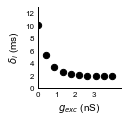

In [16]:
earr = np.linspace(0,4,10)
fig, ax = plt.subplots()
k=2.
ax.scatter(earr, [d(minDelay,k,m,e) for e in earr],s=40, facecolor='k', edgecolor='k')
ax.set_ylim(ymin=0)
ax.set_xlabel("$g_{exc}$ (nS)")
ax.set_ylabel("$\\delta_i$ (ms)")
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
ax.set_xlim(0,4.5)
ax.set_ylim(0, 13 )
ax.set_xticks(range(4))
ax.set_yticks(range(0,13,2))
simpleaxis(ax)
plt.show()

13.800000000000061


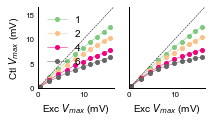

In [17]:
minDelay,k_del, m = 2.0, 0.5, 8.15

k = 2.
R = 0.8

g_exc_max = 4. #nS 
tau_exc = 12. #ms
delta_exc = 0. #mS

g_inh_max = k*g_exc_max #nS
tau_inh = R*tau_exc #ms
delta_inh = 3. #ms
delta_inh_constt = 3. #ms

tau_exc = [7,16]
tau_inh = [13,27]

# Cell parameters
g_Leak= 10. #nS taken from data
E_leak=0. #mV taken from data
E_exc=65. #mV 
E_inh=-5. #mV
Vrest=0. #mV
Cm=100. #pF
dt = 0.05 #ms
    
t, exc_cond = genSynapticCurrent(g_exc_max, delta_exc, tau_exc, dt=dt)
t, inh_cond = genSynapticCurrent(g_inh_max, delta_inh, tau_inh, dt=dt)

t, vm_trace = getVmTrace(exc_cond, inh_cond, g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)

t_peak = t[np.argmax(vm_trace)]
print(t_peak)
# gamma = find_gamma(E_exc, t_peak, tau_exc, tau_inh, delta_inh-delta_exc, k)
# print(gamma)

k_array = [1,2,4,6]
color = plt.cm.Accent(np.linspace(0,1,len(k_array)))

fig_main, ax_main = plt.subplots(ncols=2, sharey=True, sharex=True)
for k,c in zip(k_array, color):
    v_max = []
    v_max_di = []
    e_max = []
    #fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4)
    #ax4_twin= ax4.twinx()
    for dt in [0.01]:#1e-1, 1e-2, 1e-3]:
        for g in np.linspace(0.1, g_exc_max, 10):
            t, exc_cond = genSynapticCurrent(g, delta_exc, tau_exc, dt=dt)
            #ax1.plot(t[:len(t)/2],exc_cond[:len(t)/2])
            
            # Divisive Inhibition
            t, inh_cond_d = genSynapticCurrent(k*g, delta_inh_constt, tau_inh, dt=dt)
            t, vm_trace_d = getVmTrace(exc_cond, inh_cond_d, g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)
            t_max_index = np.argmax(vm_trace_d)
            t_peak = t[t_max_index]
            #ax2.plot(t, vm_trace_d)
            v_max_di.append(vm_trace_d[t_max_index])

            # Divisive Normalization
            delta_inh = d(minDelay,k_del, m,g)
            t, inh_cond = genSynapticCurrent(k*g, delta_inh, tau_inh, dt=dt)
            #ax1.plot(t[:len(t)/2],-inh_cond[:len(t)/2],'r')
            
            # Control case
            t, vm_trace = getVmTrace(exc_cond, inh_cond, g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)
            t_max_index = np.argmax(vm_trace)
            t_peak = t[t_max_index]
            #ax2.plot(t, vm_trace)
            v_max.append(vm_trace[t_max_index])
#             gamma = find_gamma(E_exc, t_peak, tau_exc, tau_inh, delta_inh-delta_exc, k)

            # GABAzine case
            t, zeroInh = genSynapticCurrent(0.*g, delta_inh, tau_inh, dt=dt)
            t, em_trace = getVmTrace(exc_cond, zeroInh , g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)
            e_max_index = np.argmax(em_trace)
            e_t_peak = t[e_max_index]
            #ax3.plot(t, em_trace)
            e_max.append(em_trace[e_max_index])

#             ax4.plot(e_max[-1], get_obs_from_gamma(e_max[-1], E_inh, gamma), 'rx')
            #ax4_twin.plot(e_max[-1], gamma, 'b.')

#     ax4.scatter(e_max, v_max, alpha=0.3, facecolors=None)
    ax_main[0].plot(e_max, v_max_di, 'o-', markersize=4, color=c, label='{}'.format(k))
    ax_main[1].plot(e_max, v_max, 'o-', markersize=4, color=c)
#     ax1.set_xlabel("Time")
#     ax1.set_ylabel("$g_{syn}$")
#     ax2.set_xlabel("Time")
#     ax2.set_ylabel("$V_m$")
#     ax3.set_xlabel("Time")
#     ax3.set_ylabel("$V_m$")
#     ax3.set_title("I=0")
#     ax4.set_ylim(ax4.get_xlim())
#     ax4.set_xlabel("$\epsilon$")
#     ax4.set_ylabel("$\\theta$")
#     simpleaxis([ax1, ax2,ax3, ax4])
#     fig.set_figwidth(16)
#     plt.show(fig)
#     plt.close(fig)

ax_main[0].set_xlim(xmin=0.)
ax_main[1].set_xlim(xmin=0.)
ax_main[0].set_ylim(ymin=0.)
ax_main[1].set_ylim(ymin=0.)

ax_main[0].set_ylim(ax_main[0].get_xlim())
ax_main[1].set_ylim(ax_main[1].get_xlim())

ax_main[0].plot((ax_main[0].get_xlim()[0],ax_main[0].get_xlim()[1]), (ax_main[0].get_ylim()[0],ax_main[0].get_ylim()[1]) , '--')
ax_main[1].plot((ax_main[1].get_xlim()[0],ax_main[1].get_xlim()[1]), (ax_main[1].get_ylim()[0],ax_main[1].get_ylim()[1]) , '--')


# ax_main[0].set_xlabel("$\epsilon$ (mV)")
# ax_main[0].set_ylabel("$\\theta$ (mV)")
# ax_main[1].set_xlabel("$\epsilon$ (mV)")

ax_main[0].set_xlabel("Exc $V_{max}$ (mV)")
ax_main[0].set_ylabel("Ctl $V_{max}$ (mV)")
ax_main[1].set_xlabel("Exc $V_{max}$ (mV)")

simpleaxis(ax_main)
ax_main[0].legend()
fig_main.set_figwidth(3)
fig_main.set_figheight(1.5)
plt.savefig('figures/fig6/DI_DN.svg')
plt.show()
plt.close()

### Just the excitation first

14.750000000000075


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


Eta is 0.0, omega is 0.0, gamma is inf
Eta is 0.0, omega is 0.0, gamma is inf
Eta is 0.0, omega is 0.0, gamma is inf
Eta is 0.0, omega is 0.0, gamma is inf
Eta is 0.0, omega is 0.0, gamma is inf
Eta is 0.0, omega is 0.0, gamma is inf
Eta is 0.0, omega is 0.0, gamma is inf
Eta is 0.0, omega is 0.0, gamma is inf
Eta is 0.0, omega is 0.0, gamma is inf
Eta is 0.0, omega is 0.0, gamma is inf
Eta is -0.0742411189381, omega is 1.37923917372, gamma is 41.7770933743
Eta is -0.105233957514, omega is 1.34296257849, gamma is 40.8928017724
Eta is -0.130840227844, omega is 1.30834995412, gamma is 40.363269724
Eta is -0.152549714228, omega is 1.27633606237, gamma is 40.0347260432
Eta is -0.170802259456, omega is 1.24674493135, gamma is 39.865217734
Eta is -0.185611487719, omega is 1.22020888828, gamma is 39.8209853586
Eta is -0.1990553556, omega is 1.19506134136, gamma is 39.8284299761
Eta is -0.210105495565, omega is 1.17211545486, gamma is 39.9143046285
Eta is -0.220322141514, omega is 1.1502082576

/usr/local/lib/python2.7/dist-packages/matplotlib/legend.py:1339: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if f_h.get_color() != h.get_color():


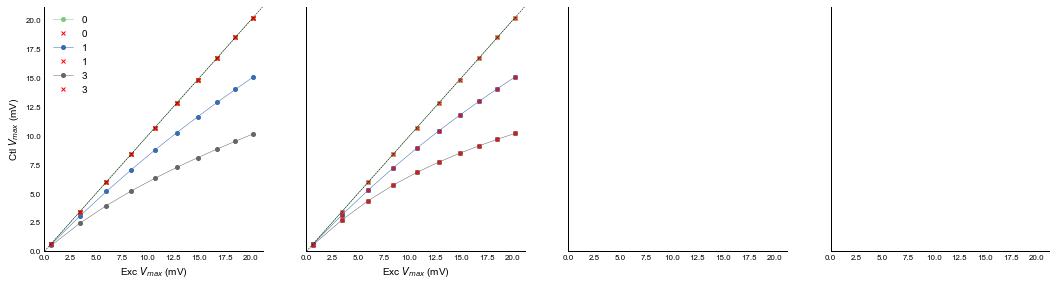

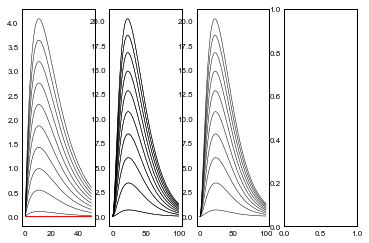

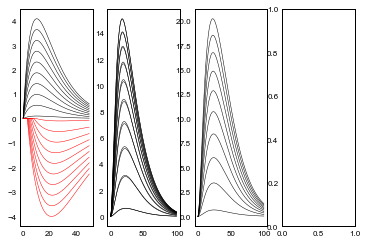

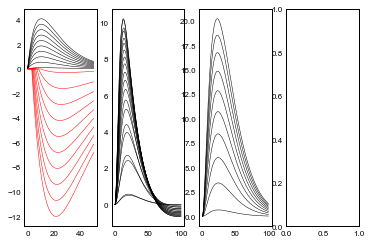

In [18]:
minDelay,k_del, m = 2.0, 0.5, 8.15

k = 2.
R = 0.8

g_exc_max = 4. #nS 
tau_exc = 12. #ms
delta_exc = 0. #mS

g_inh_max = k*g_exc_max #nS
tau_inh = R*tau_exc #ms
delta_inh = 3. #ms
delta_inh_constt = 3. #ms

tau_exc = [7,16]
tau_inh = [13,27]

# Cell parameters
g_Leak= 6.25 #nS taken from data
E_leak=0. #mV taken from data
E_exc=65. #mV 
E_inh=-5. #mV
Vrest=0. #mV
Cm=100. #pF
dt = 0.05 #ms
    
t, exc_cond = genSynapticCurrent(g_exc_max, delta_exc, tau_exc, dt=dt)

t, inh_cond = genSynapticCurrent(g_inh_max, delta_inh, tau_inh, dt=dt)

t, vm_trace = getVmTrace(exc_cond, inh_cond, g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)

t_peak = t[np.argmax(vm_trace)]
print(t_peak)
# gamma = find_gamma(E_exc, t_peak, tau_exc, tau_inh, delta_inh-delta_exc, k)
# print(gamma)

k_array = [0,1,3]
color = plt.cm.Accent(np.linspace(0,1,len(k_array)))

fig_main, ax_main = plt.subplots(ncols=4, sharey=True, sharex=True)
for k,c in zip(k_array, color):
    v_max = []
    v_max_di = []
    v_max_di_calc = []
    v_max_dn_calc = []
    e_max = []
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4)
    #ax4_twin= ax4.twinx()
    for dt in [0.01]:#1e-1, 1e-2, 1e-3]:
        for g in np.linspace(0.1, g_exc_max, 10):
            t, exc_cond = genSynapticCurrent(g, delta_exc, tau_exc, dt=dt)
            ax1.plot(t[:len(t)/2],exc_cond[:len(t)/2])
            
            # Divisive Inhibition
            t, inh_cond_d = genSynapticCurrent(k*g, delta_inh_constt, tau_inh, dt=dt)
            t, vm_trace_d = getVmTrace(exc_cond, inh_cond_d, g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)
            t_max_index = np.argmax(vm_trace_d)
            t_peak = t[t_max_index]
            ax2.plot(t, vm_trace_d)
            v_max_di.append(vm_trace_d[t_max_index])

            # Divisive Normalization
            delta_inh = d(minDelay,k_del, m,g)
            t, inh_cond = genSynapticCurrent(k*g, delta_inh, tau_inh, dt=dt)
            ax1.plot(t[:len(t)/2],-inh_cond[:len(t)/2],'r')
            
            # Control case
            t, vm_trace = getVmTrace(exc_cond, inh_cond, g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)
            t_max_index = np.argmax(vm_trace)
            t_peak = t[t_max_index]
            ax2.plot(t, vm_trace)
            v_max.append(vm_trace[t_max_index])
#             gamma = find_gamma(E_exc, t_peak, tau_exc, tau_inh, delta_inh-delta_exc, k)

            # GABAzine case
            t, zeroInh = genSynapticCurrent(0.*g, delta_inh, tau_inh, dt=dt)
            t, em_trace = getVmTrace(exc_cond, zeroInh , g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)
            e_max_index = np.argmax(em_trace)
            e_t_peak = t[e_max_index]
            ax3.plot(t, em_trace)
            e_max.append(em_trace[e_max_index])
            
            omega = inh_cond[t_max_index]/exc_cond[t_max_index]
            eta = 1 - (exc_cond[t_max_index]/exc_cond[e_max_index])           
            gamma = E_exc/(omega*(1-eta) - eta)
            
            print("Eta is {}, omega is {}, gamma is {}".format(eta, omega, gamma))
            v_max_di_calc.append(exc_cond[e_max_index]*E_exc/(g_Leak + exc_cond[e_max_index]))
            #v_max_dn_calc.append((exc_cond[t_max_index]*E_exc + inh_cond[t_max_index]*E_inh) /(g_Leak + exc_cond[t_max_index]+ inh_cond[t_max_index]))
            
            analytic_v_max_dn = em_trace[e_max_index] * (1 - (em_trace[e_max_index] + eta*gamma - ((omega*(1-eta) * E_inh)/(omega*(1-eta) - eta)) )/(em_trace[e_max_index] + gamma)     )
            if gamma == np.inf:
                analytic_v_max_dn = em_trace[e_max_index]
            v_max_dn_calc.append(analytic_v_max_dn)

#             ax4.plot(e_max[-1], get_obs_from_gamma(e_max[-1], E_inh, gamma), 'rx')
            #ax4_twin.plot(e_max[-1], gamma, 'b.')
    

    
#     ax4.scatter(e_max, v_max, alpha=0.3, facecolors=None)
    ax_main[0].plot(e_max, v_max_di, 'o-', markersize=4, color=c, label='{}'.format(k))
    ax_main[1].plot(e_max, v_max, 'o-', markersize=4, color=c)
    ax_main[0].plot(e_max, v_max_di_calc, 'x', markersize=4, color='r', label='{}'.format(k))
    ax_main[1].plot(e_max, v_max_dn_calc, 'x', markersize=4, color='r')
#     ax1.set_xlabel("Time")
#     ax1.set_ylabel("$g_{syn}$")
#     ax2.set_xlabel("Time")
#     ax2.set_ylabel("$V_m$")
#     ax3.set_xlabel("Time")
#     ax3.set_ylabel("$V_m$")
#     ax3.set_title("I=0")
#     ax4.set_ylim(ax4.get_xlim())
#     ax4.set_xlabel("$\epsilon$")
#     ax4.set_ylabel("$\\theta$")
#     simpleaxis([ax1, ax2,ax3, ax4])
#     fig.set_figwidth(16)
#     plt.show(fig)
#     plt.close(fig)

ax_main[0].set_xlim(xmin=0.)
ax_main[1].set_xlim(xmin=0.)
ax_main[0].set_ylim(ymin=0.)
ax_main[1].set_ylim(ymin=0.)

ax_main[0].set_ylim(ax_main[0].get_xlim())
ax_main[1].set_ylim(ax_main[1].get_xlim())

ax_main[0].plot((ax_main[0].get_xlim()[0],ax_main[0].get_xlim()[1]), (ax_main[0].get_ylim()[0],ax_main[0].get_ylim()[1]) , '--')
ax_main[1].plot((ax_main[1].get_xlim()[0],ax_main[1].get_xlim()[1]), (ax_main[1].get_ylim()[0],ax_main[1].get_ylim()[1]) , '--')


# ax_main[0].set_xlabel("$\epsilon$ (mV)")
# ax_main[0].set_ylabel("$\\theta$ (mV)")
# ax_main[1].set_xlabel("$\epsilon$ (mV)")

ax_main[0].set_xlabel("Exc $V_{max}$ (mV)")
ax_main[0].set_ylabel("Ctl $V_{max}$ (mV)")
ax_main[1].set_xlabel("Exc $V_{max}$ (mV)")

simpleaxis(ax_main)
ax_main[0].legend()
fig_main.set_figwidth(18)
fig_main.set_figheight(4.5)
plt.savefig('figures/fig6/DI_DN.svg')
plt.show()
plt.close()

In [19]:
color = plt.cm.viridis(np.linspace(0,1,k))

## Double exponentials instead of alpha functions

[5.2, 14] [48.0, 36.0]
16.350000000000097


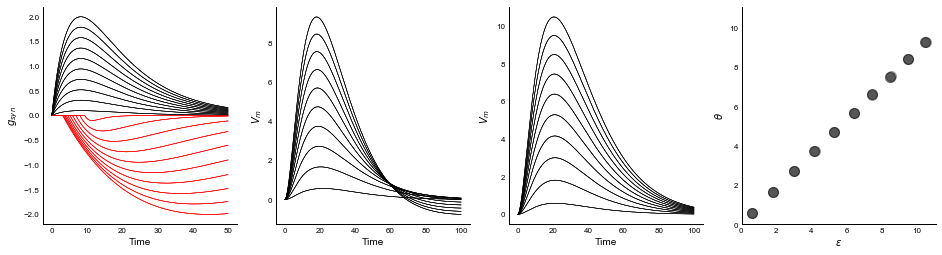

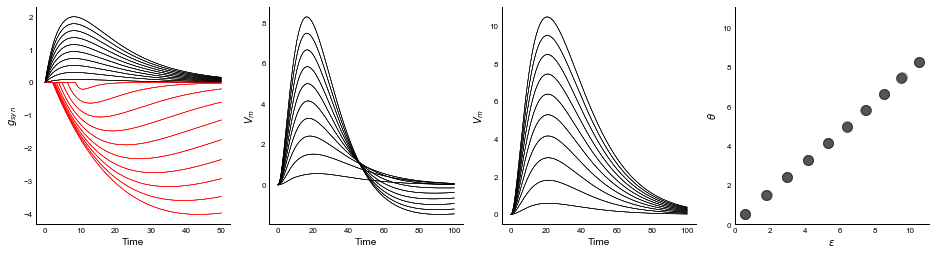

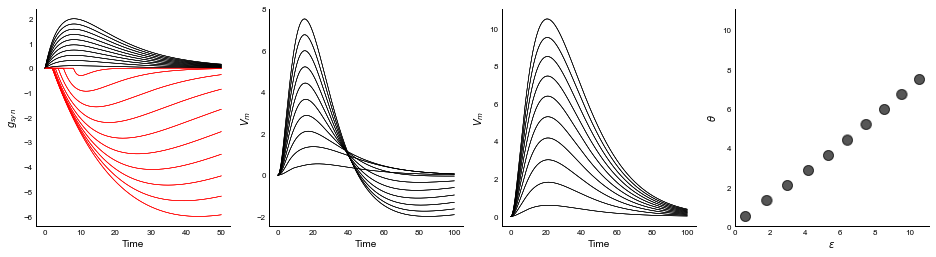

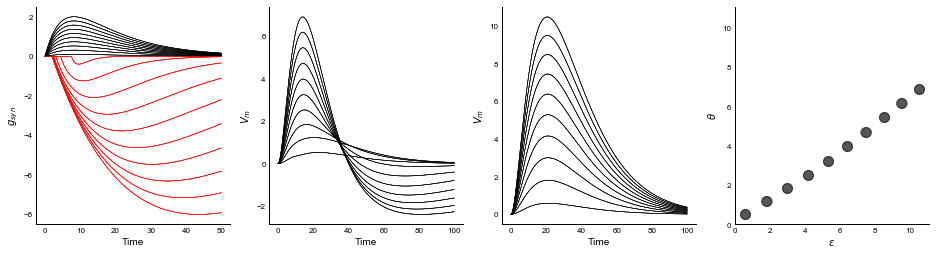

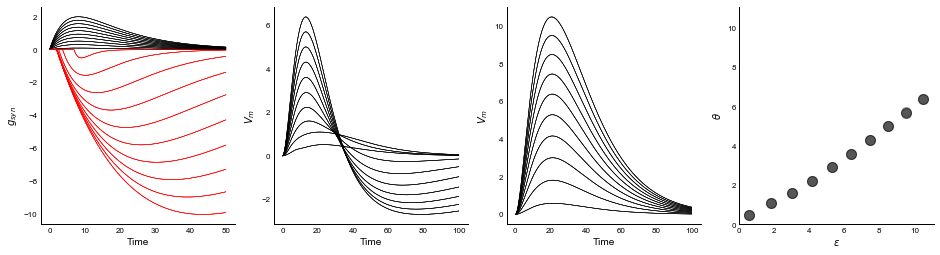

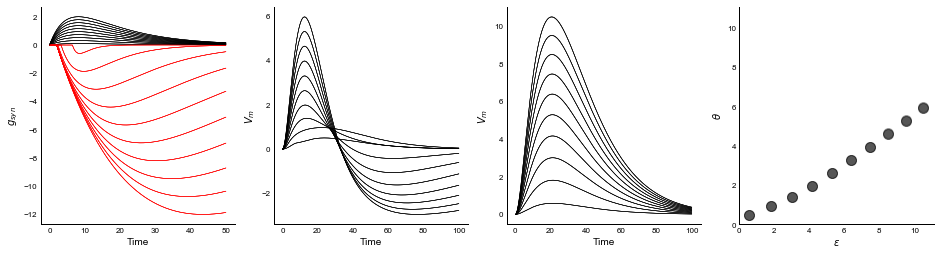

In [20]:
k = 2.
R = 0.8

g_exc_max = 2. #nS 

t_on_e  = lambda g_e: 5.2
t_off_e = lambda g_e: 14
t_on_i  = lambda g_e: g_e * 24 
t_off_i = lambda g_e: g_e *18

delta_exc = 0. #mS

g_inh_max = k*g_exc_max #nS

tau_exc = [t_on_e(g_exc_max), t_off_e(g_exc_max)]
tau_inh = [t_on_i(g_exc_max), t_off_i(g_exc_max)]

print (tau_exc, tau_inh)
delta_inh = 3. #ms

# Cell parameters
g_Leak=6.25 #nS taken from data
E_leak=0. #mV taken from data
E_exc=65. #mV 
E_inh=-5. #mV
Vrest=0. #mV
Cm=100. #pF
dt = 0.05 #ms
    
t, exc_cond = genSynapticCurrent(g_exc_max, delta_exc, tau_exc, dt=dt)
t, inh_cond = genSynapticCurrent(g_inh_max, delta_inh, tau_inh, dt=dt)

t, vm_trace = getVmTrace(exc_cond, inh_cond, g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)

t_peak = t[np.argmax(vm_trace)]
print(t_peak)
# gamma = find_gamma(E_exc, t_peak, tau_exc, tau_inh, delta_inh-delta_exc, k)
# print(gamma)


for k in [1,2,3,4,5,6]:
    v_max = []
    e_max = []
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4)
    #ax4_twin= ax4.twinx()
    for dt in [1e-1, 1e-2, 1e-3]:
        for g in np.linspace(0.1, g_exc_max, 10):
            
            tau_exc = [t_on_e(g), t_off_e(g)]
            tau_inh = [t_on_i(g), t_off_i(g)]
            
            t, exc_cond = genSynapticCurrent(g, delta_exc, tau_exc, dt=dt)
            ax1.plot(t[:len(t)/2],exc_cond[:len(t)/2])
            
            delta_inh = d(minDelay,k,m,g)
            t, inh_cond = genSynapticCurrent(k*g, delta_inh, tau_inh, dt=dt)
            ax1.plot(t[:len(t)/2],-inh_cond[:len(t)/2],'r')

            # Control case
            t, vm_trace = getVmTrace(exc_cond, inh_cond, g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)
            t_max_index = np.argmax(vm_trace)
            t_peak = t[t_max_index]
            ax2.plot(t, vm_trace)
            v_max.append(vm_trace[t_max_index])
#             gamma = find_gamma(E_exc, t_peak, tau_exc, tau_inh, delta_inh-delta_exc, k)


            # GABAzine case
            t, zeroInh = genSynapticCurrent(0.*g, delta_inh, tau_inh, dt=dt)
            t, em_trace = getVmTrace(exc_cond, zeroInh , g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)
            e_max_index = np.argmax(em_trace)
            e_t_peak = t[e_max_index]
            ax3.plot(t, em_trace)
            e_max.append(em_trace[e_max_index])

#             ax4.plot(e_max[-1], get_obs_from_gamma(e_max[-1], E_inh, gamma), 'rx')
            #ax4_twin.plot(e_max[-1], gamma, 'b.')

    ax4.scatter(e_max, v_max, alpha=0.3, facecolors=None)

    ax1.set_xlabel("Time")
    ax1.set_ylabel("$g_{syn}$")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("$V_m$")
    ax3.set_xlabel("Time")
    ax3.set_ylabel("$V_m$")
    ax3.set_title("I=0")
    ax4.set_ylim(ax4.get_xlim())
    ax4.set_xlabel("$\epsilon$")
    ax4.set_ylabel("$\\theta$")
    simpleaxis([ax1, ax2,ax3, ax4])
    fig.set_figwidth(16)
    plt.show()
    plt.close()

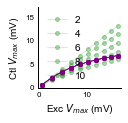

In [21]:
k = 2.
R = 0.8

g_exc_max = 4. #nS 
tau_exc = 12. #ms
delta_exc = 0. #mS

g_inh_max = k*g_exc_max #nS
tau_inh = R*tau_exc #ms
delta_inh = 3. #ms

# Cell parameters
g_Leak = 10. # 6.25 nS taken from data
E_leak = 0. #mV taken from data
E_exc = 65. #mV 
E_inh = -5. #mV
Vrest = 0. #mV
Cm = 100. #pF
dt = 0.05 #ms
    
# t, exc_cond = genSynapticCurrent(g_exc_max, delta_exc, tau_exc, dt=dt)
# t, inh_cond = genSynapticCurrent(g_inh_max, delta_inh, tau_inh, dt=dt)

# t, vm_trace = getVmTrace(exc_cond, inh_cond, g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)

# t_peak = t[np.argmax(vm_trace)]
# print(t_peak)
# gamma = find_gamma(E_exc, t_peak, tau_exc, tau_inh, delta_inh-delta_exc, k)
# print(gamma)

e_tau = [6,17]
i_tau = [9,24]

for k in [5]:

    #fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4)
    fig, ax4 = plt.subplots()
    #ax4_twin= ax4.twinx()
    dt = 0.01
    #for dt in [1e-1, 1e-2, 1e-3]:
    for delta_inh_constt in [2,4,6,8,10]:
        v_max = []
        v_max_d = []
        e_max = []
        for g in np.linspace(0.1, g_exc_max, 10):
            t, exc_cond = genSynapticCurrent(g, delta_exc, e_tau, dt=dt)
    #             print(exc_cond)
#             ax1.plot(t[:len(t)/2],exc_cond[:len(t)/2])

            #delta_inh = d(minDelay,k,m,g)
            #delta_inh = 2.
            t, inh_cond = genSynapticCurrent(k*g, delta_inh_constt, i_tau, dt=dt)
#             ax1.plot(t[:len(t)/2],-inh_cond[:len(t)/2],'r')

            # Control case
            t, vm_trace = getVmTrace(exc_cond, inh_cond, g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)
            t_max_index = np.argmax(vm_trace)
            t_peak = t[t_max_index]
#             ax2.plot(t, vm_trace, color='g')
#             ax2.scatter(t_peak, vm_trace[t_max_index], color='g', s=12)

            v_max.append(vm_trace[t_max_index])
            gamma = find_gamma(E_exc, t_peak, tau_exc, tau_inh, delta_inh-delta_exc, k)

            # Control case with delay
            delta_inh = d(2.0, 0.5, 8.15, g)
            t, inh_cond = genSynapticCurrent(k*g, delta_inh, i_tau, dt=dt)
#             ax1.plot(t[:len(t)/2],-inh_cond[:len(t)/2],'r--')

            t, vm_trace = getVmTrace(exc_cond, inh_cond, g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)
            t_max_index = np.argmax(vm_trace)
            t_peak = t[t_max_index]
#             ax2.plot(t, vm_trace, color='purple')
#             ax2.scatter(t_peak, vm_trace[t_max_index], color='purple', s=12)
            v_max_d.append(vm_trace[t_max_index])
            
            # GABAzine case
            t, zeroInh = genSynapticCurrent(0.*g, delta_inh, i_tau, dt=dt)
            t, em_trace = getVmTrace(exc_cond, zeroInh , g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)
            e_max_index = np.argmax(em_trace)
            e_t_peak = t[e_max_index]
#             ax3.plot(t, em_trace)
            e_max.append(em_trace[e_max_index])

            #ax4.plot(e_max[-1], get_obs_from_gamma(e_max[-1], E_inh, gamma), 'rx')
            #ax4_twin.plot(e_max[-1], gamma, 'b.')

        ax4.plot(e_max, v_max, 'o-', color='g', markersize=4, alpha=0.3, label='{}'.format(delta_inh_constt))
        ax4.plot(e_max, v_max_d, 'o-', color='purple', markersize=4)

#     ax1.set_xlabel("Time")
#     ax1.set_ylabel("$g_{syn}$")
#     ax2.set_xlabel("Time")
#     ax2.set_ylabel("$V_m$")
#     ax3.set_xlabel("Time")
#     ax3.set_ylabel("$V_m$")
#     ax3.set_title("I=0")
    ax4.set_ylim(ax4.get_xlim())
    ax4.set_xlabel("Exc $V_{max}$ (mV)")
    ax4.set_ylabel("Ctl $V_{max}$ (mV)")
#     simpleaxis([ax1, ax2,ax3, ax4])
    ax4.legend()
    simpleaxis(ax4)
    fig.set_figwidth(1.5)
    fig.set_figheight(1.5)
    plt.savefig('figures/fig6/6_delays.svg')
    plt.show()
    plt.close()

TypeError: only integer scalar arrays can be converted to a scalar index

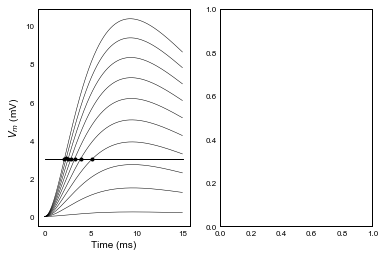

In [22]:
v_max = []
e_max = []


dt = 0.05

# Cell parameters
tau_exc = 3. #ms
threshold = 3
plot_time = 15
g_Leak = 8.62 #nS Interneurons
Cm = 112 #pF


g_exc_max = 5. #nS 
delta_exc = 0. #mS
delta_inh = 3. #ms

E_leak=0. #mV
E_exc=57. #mV
E_inh=-8. #mV

Vrest=0. #mV




spike_times = []
fig, (ax1, ax2) = plt.subplots(ncols=2)
g_array =  []
for g in np.linspace(0.1, g_exc_max, 10):

    # GABAzine case
    t, exc_cond = genSynapticCurrent(g, delta_exc, tau_exc, dt=dt)
    t, zeroInh = genSynapticCurrent(0.*g, delta_inh, tau_inh, dt=dt)
    t, em_trace = getVmTrace(exc_cond, zeroInh , g_Leak=g_Leak, E_leak=E_leak, E_exc=E_exc, E_inh=E_inh, Cm=Cm, Vrest=Vrest, dt=dt)
    
    ax1.plot(t[:int(plot_time/dt)], em_trace[:int(plot_time/dt)])
    indices = np.where(em_trace>threshold)[0]
    if len(indices):
        ax1.plot(t[indices[0]], em_trace[indices[0]], 'o', markersize=3)
        spike_times.append(indices[0]*dt)
        g_array.append(g)
    else:
        pass
    ax1.hlines(y=threshold, xmin=0, xmax=plot_time)

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("$V_m$ (mV)")

colors = matplotlib.cm.plasma[np.arange(0,1,len(spike_times))]
ax2.plot(g_array, spike_times, '.-', color=colors)
ax2.set_xlim(xmin=0.)
ax2.set_ylim(ymin=0.)
ax2.set_xlabel("$g_{exc}$ (nS)")
ax2.set_ylabel("Spk. tm (ms)")

simpleaxis([ax1, ax2])
fig.set_figheight(2)
fig.set_figwidth(4)
dump(fig,file('figures/supplementary/interneuron_spk_tm.pkl','wb'))
plt.legend()
plt.show()

In [23]:
gamma_mat = [[[find_gamma(E_exc, t_peak, tau_exc, R*tau_exc, delta, k) for delta in np.arange(1,5,0.5)] for k in np.arange(1,6,0.5)] for R in np.arange(0.5, 2, 0.3)]

0.5


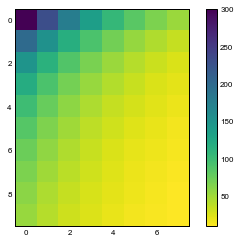

0.8


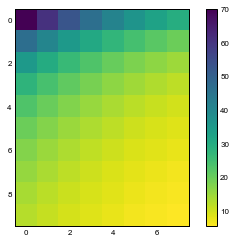

1.1


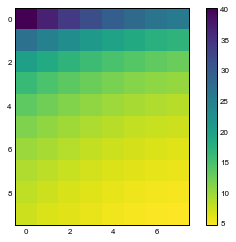

1.4000000000000001


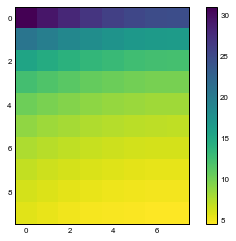

1.7000000000000002


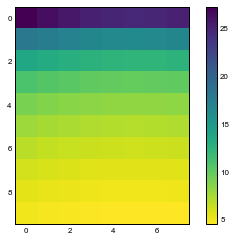

In [24]:
for R_val, gamma_heat in zip(np.arange(0.5, 2, 0.3), gamma_mat):
    print (R_val)
    fig, ax = plt.subplots()
    cbar = ax.imshow(gamma_heat, cmap=matplotlib.cm.viridis_r)
    plt.colorbar(cbar)
    plt.show()

In [25]:
print (gamma_mat)

[[[300.46765695245455, 230.2454898559823, 177.28990130171974, 137.27842382567232, 106.99273533532322, 84.03514918627984, 66.61954064248675, 53.41772328619276], [200.31177130163636, 153.49699323732153, 118.19326753447983, 91.51894921711488, 71.32849022354881, 56.02343279085323, 44.41302709499116, 35.61181552412851], [150.23382847622727, 115.12274492799115, 88.64495065085987, 68.63921191283616, 53.49636766766161, 42.01757459313992, 33.30977032124338, 26.70886164309638], [120.1870627809818, 92.09819594239292, 70.9159605206879, 54.911369530268935, 42.79709413412929, 33.61405967451194, 26.647816256994698, 21.367089314477106], [100.15588565081818, 76.74849661866077, 59.096633767239915, 45.75947460855744, 35.664245111774406, 28.011716395426614, 22.20651354749558, 17.805907762064255], [85.84790198641556, 65.78442567313779, 50.654257514777065, 39.22240680733495, 30.56935295294949, 24.010042624651383, 19.034154469281926, 15.26220665319793], [75.11691423811364, 57.561372463995575, 44.322475325429

c2_EI 161220


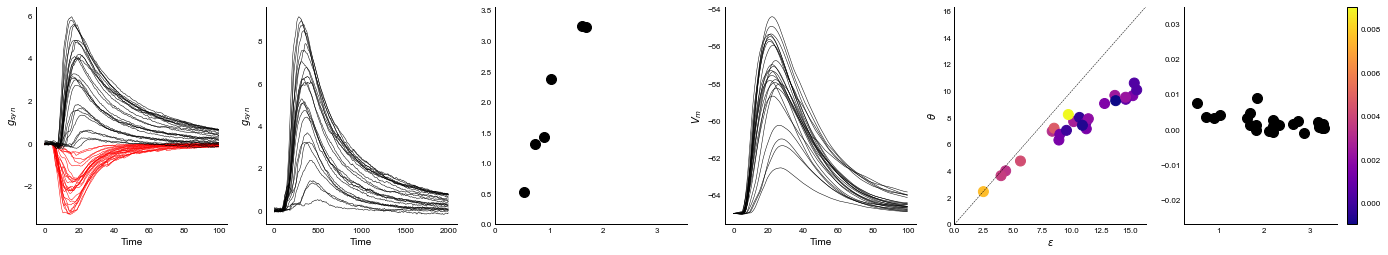

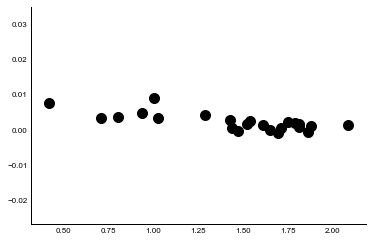

c2_EI 170510


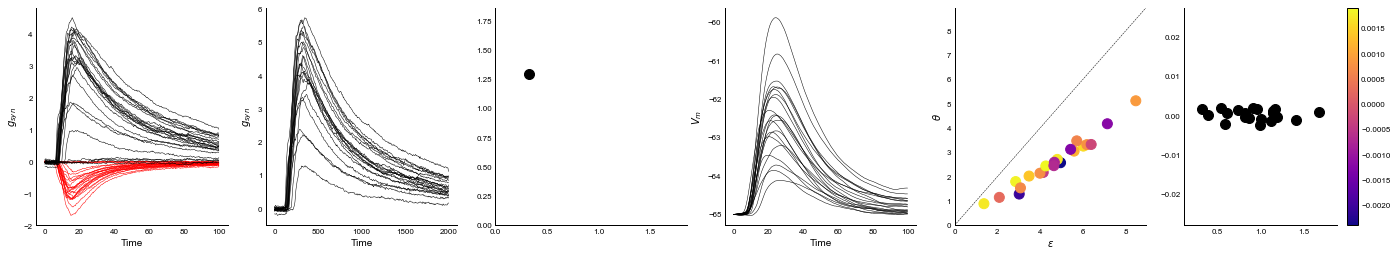

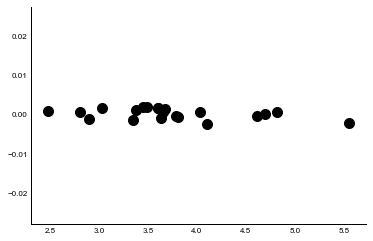

c3_EI 170524


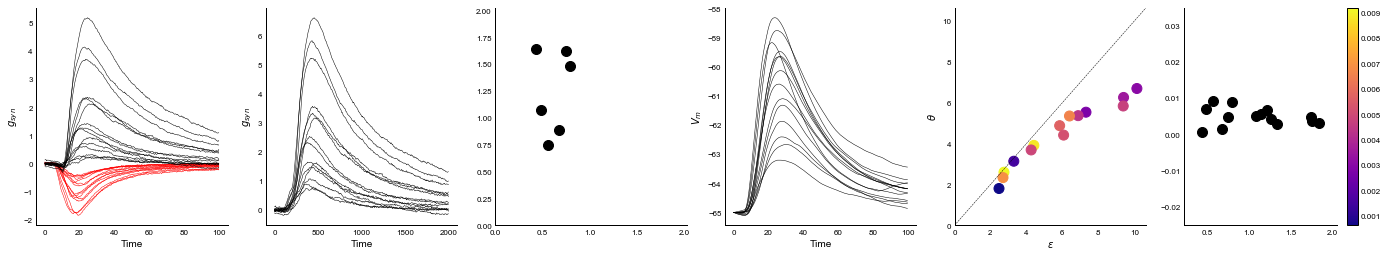

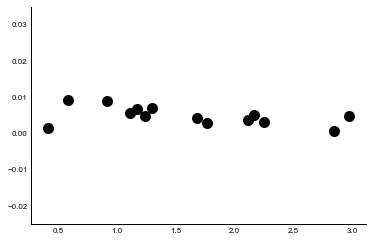

c1_EI 170524


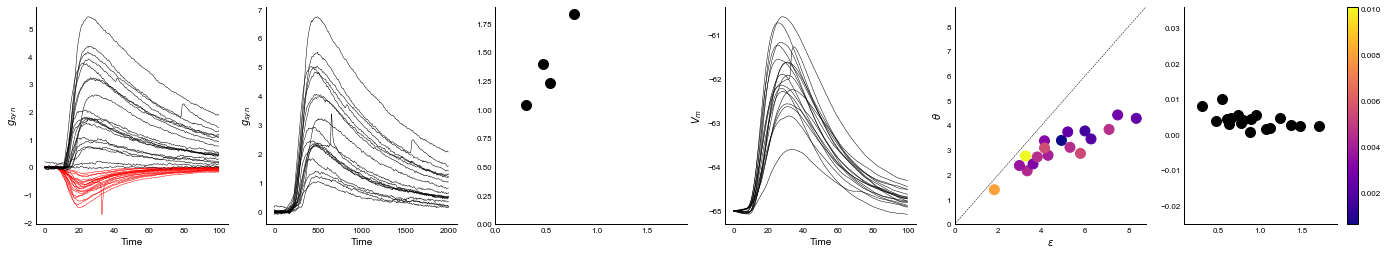

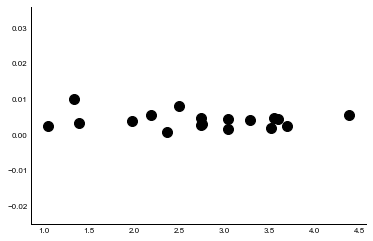

c2_EI 170530


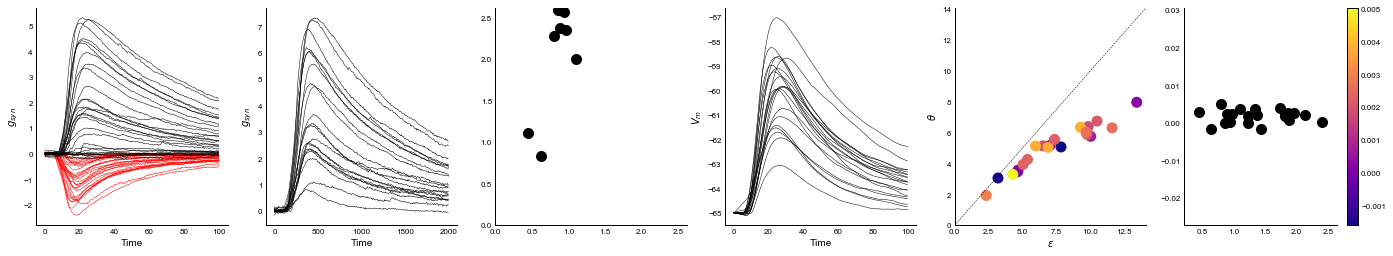

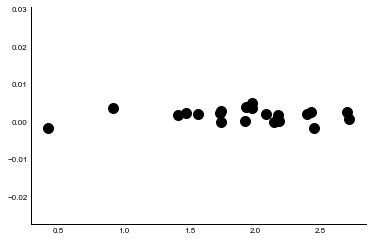

c1_EI 170530


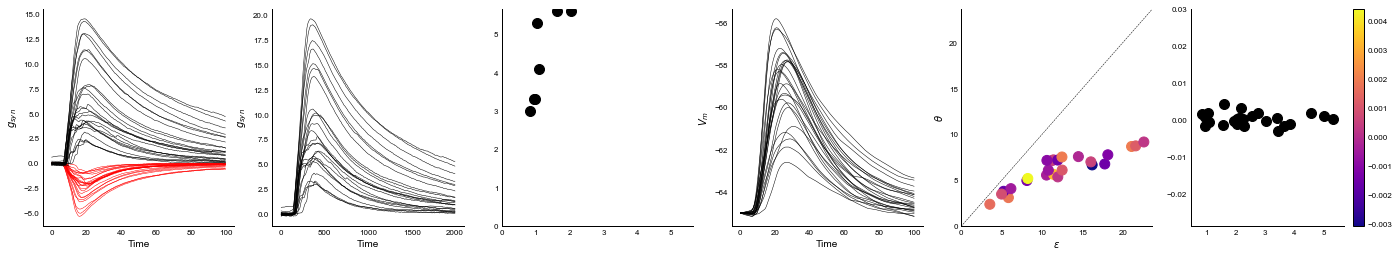

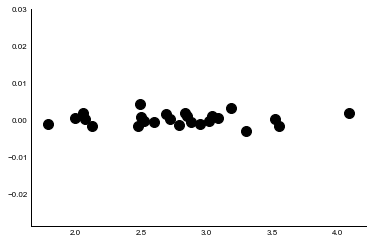

c2_EI 170531


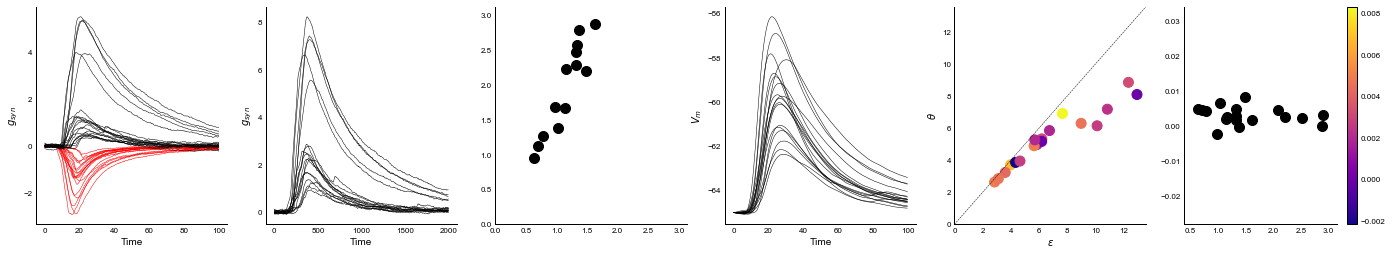

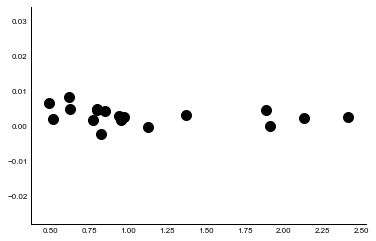

c4_EI 170531


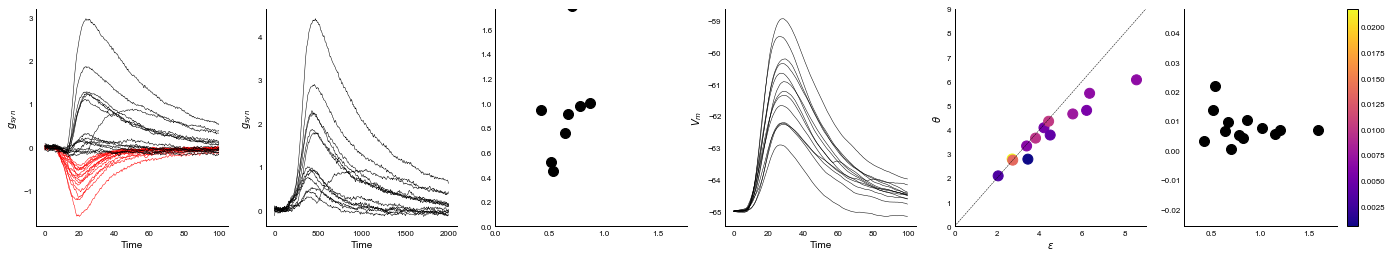

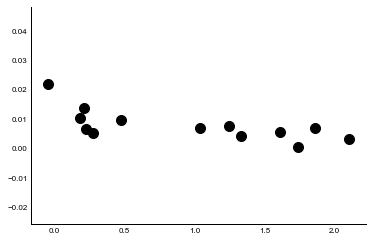

c1_EI 170531


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice


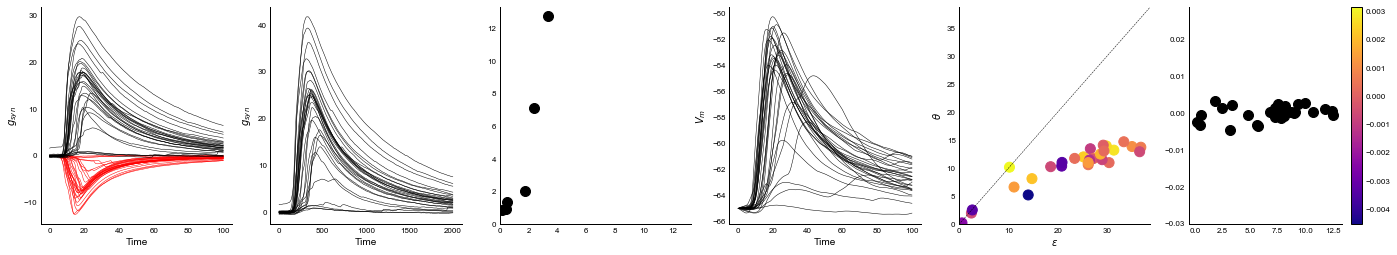

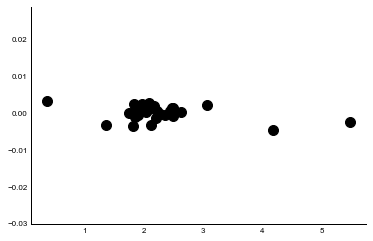

c5_EI 170720


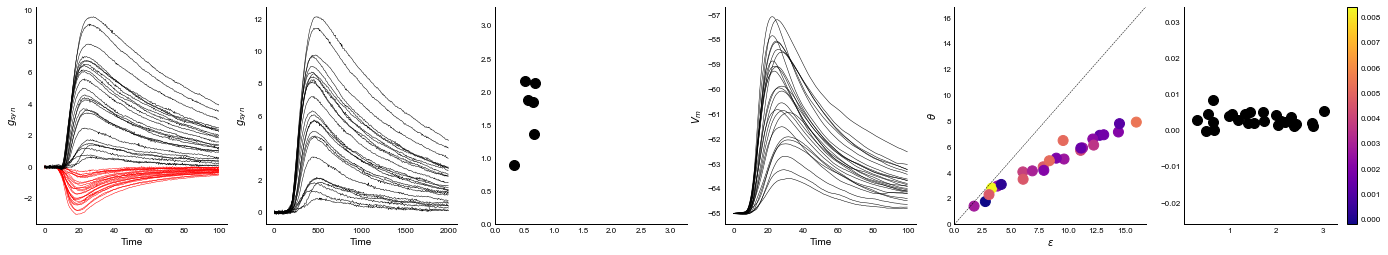

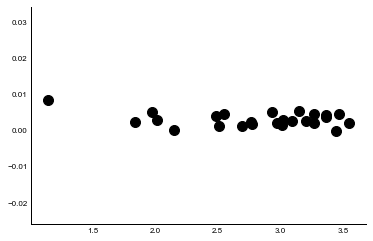

c3_EI 170720


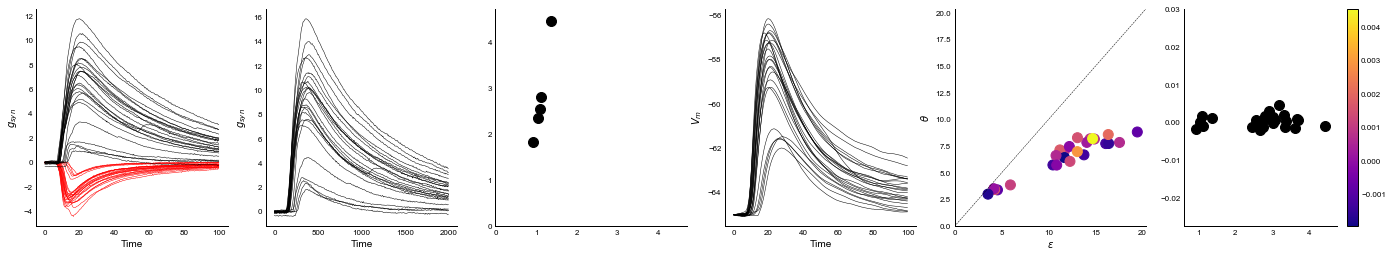

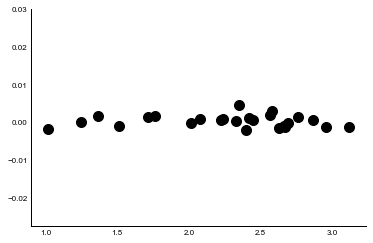

c4_EI 170720


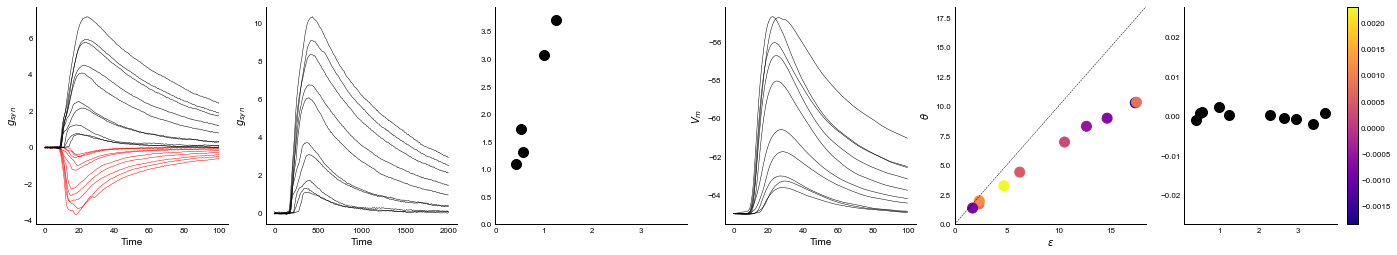

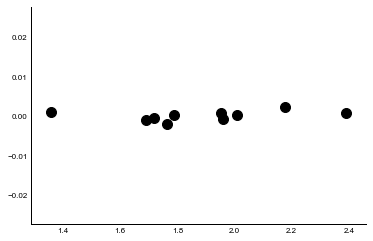

c2_EI 170720


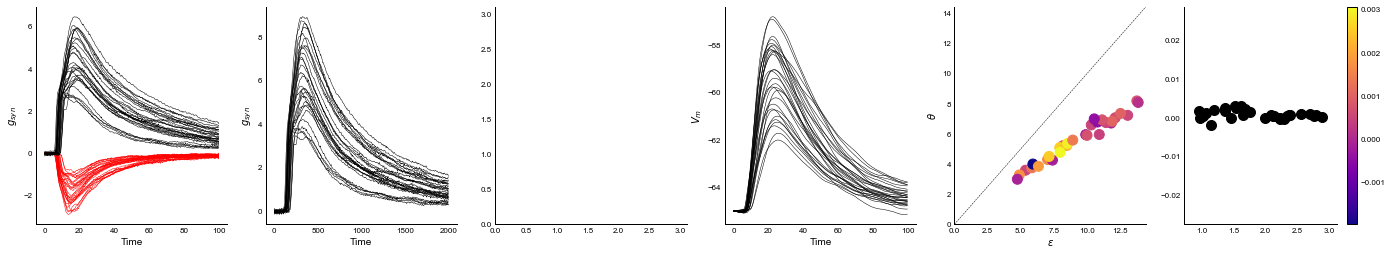

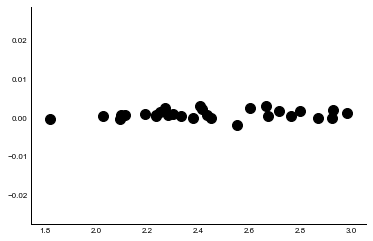

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from matplotlib import mlab
from scipy.optimize import curve_fit

feature = 1
areaScalingFactor = 1e9 # nA.ms
scalingFactor = areaScalingFactor
r_squared = []
slopes = []
valid_neurons = []
studentised_res = []
coord_sqr_all_cells = []
nanosiemens = 1e9    


k = 2.
R = 0.8

g_exc_max = 5. #nS 
tau_exc = 12. #ms
delta_exc = 0. #mS

g_inh_max = k*g_exc_max #nS
tau_inh = R*tau_exc #ms
delta_inh = 3. #ms

# Cell parameters
g_Leak=6.25 #nS taken from data
E_leak=0. #mV taken from data
E_exc=65. #mV 
E_inh=-5. #mV
Vrest=0. #mV
Cm=100. #pF
dt = 0.05 #ms

for index, n in enumerate(neurons):
    n = neurons[index]
    print(n.index, n.date)
    obs_exc, obs_inh = {}, {}
    exc_error, inh_error = {}, {}
    del_exc, del_inh = {}, {}
    tau_exc_dict, tau_inh_dict, delta_exc_dict, delta_inh_dict, g_exc_dict, g_inh_dict = {}, {}, {}, {}, {}, {}
    ttp_exc, ttp_inh = {}, {}
    amplitude = {}
    sqrs = []
    coord_sqrs = {}

    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(ncols=6)
    for expType,expt in n:
        for sqr in expt:
            #if sqr == 1 or sqr == 2:
                if (expType == 1):
                    sqrs.append(sqr)
                    for coord in expt[sqr].coordwise:
                        trajectory = []
                        delays = []
                        for trial in expt[sqr].coordwise[coord].trials:
                            trajectory.append(trial.interestWindow)
                            onset = findOnsetTime(trial)
                            #onset = np.argmin(trial.interestWindow)/20.
                            if onset:
                                delays.append(onset)
                        obs_exc[coord] = np.average(trajectory,axis=0)*nanosiemens/-70
                        del_exc[coord] = np.nanmean(delays)
                        t_arr = np.linspace(0,100,len(obs_exc[coord]))
                        ax1.plot(t_arr, -obs_exc[coord],c='r') 
#                         popt, pcov = curve_fit(alphaSynapse, t_arr, obs_exc[coord])
#                         g_exc_dict[coord], delta_exc_dict[coord], tau_exc_dict[coord] = popt
                        ttp_exc[coord] = t_arr[np.argmax(obs_exc[coord])]
#                         ax1.plot(t_arr, -np.array(alphaSynapse(t_arr, *popt)), 'b-')

                elif (expType == 2):
                    for coord in expt[sqr].coordwise:
                        trajectory = []
                        delays = []
                        for trial in expt[sqr].coordwise[coord].trials:
                            trajectory.append(trial.interestWindow)
                            onset = findOnsetTime(trial)
                            #onset = np.argmax(trial.interestWindow)/20.
                            if onset:
                                delays.append(onset)
                        obs_inh[coord] = np.average(trajectory,axis=0)*nanosiemens/70
                        del_inh[coord] = np.nanmean(delays)
                        t_arr = np.linspace(0,100,len(obs_inh[coord]))
                        ax1.plot(t_arr, obs_inh[coord])
#                         popt, pcov = curve_fit(alphaSynapse, t_arr, obs_inh[coord])
#                         g_inh_dict[coord], delta_inh_dict[coord], tau_inh_dict[coord] = popt
                        ttp_inh[coord] = t_arr[np.argmax(obs_inh[coord])]
#                         ax1.plot(t_arr, np.array(alphaSynapse(t_arr, *popt)), 'b-')
                        
    totalTrajectory = {}
    excScale = 1
    exc_max = []
    pred_obs_max = []
    truepredTraj = {}
    truepred_exc = {}
    exc_max = []
    pred_obs_max = []
    true_exc_max = []
    true_pred_obs_max = []
    delays = []
    fit_delays = []
    nanosiemens = 1e9
    tau_exc = []
    tau_inh = []
    tau_ratio = []
    ttp_ratio = []
    ie_ratio= []
    
    for coord in set(obs_exc.keys()).intersection(set(obs_inh.keys())):
        totalTrajectory[coord] = obs_exc[coord] + obs_inh[coord]
        #print (np.average(pred_g_exc))
        #truepredTraj[coord] = (1/Cm)*(g_leak*(Vm-E_leak) + pred_g_exc*(Vm-E_exc) + pred_g_inh*(Vm-E_inh))
        #print (truepredTraj[coord])
        
        # Now for true(er) predictions
        pred_g_exc = obs_exc[coord]
        pred_g_inh = obs_inh[coord]
        Vrest = -65
        
        if ( max(pred_g_exc) > 0.5) or ( max(pred_g_inh) > 0.5):
            ax2.plot(totalTrajectory[coord]) # Depolarization upward
            exc_max.append(max(obs_exc[coord]))
            pred_obs_max.append(max(totalTrajectory[coord]))

            time, truepredTraj[coord] = getVmTrace(pred_g_exc, pred_g_inh, Vrest=Vrest)
            time, truepred_exc[coord] = getVmTrace(pred_g_exc, np.zeros(len(pred_g_exc)), Vrest=Vrest)

            ax4.plot(time, truepredTraj[coord]) # Depolarization upward

            true_exc_max.append(max(truepred_exc[coord]) - Vrest)
            true_pred_obs_max.append(max(truepredTraj[coord]) - Vrest)
            
            ie_ratio.append(max(pred_g_inh)/max(pred_g_exc))
            delays.append(del_inh[coord] - del_exc[coord])
#         fit_delays.append(delta_inh_dict[coord] - delta_exc_dict[coord])
    #         print(tau_inh_dict[coord],tau_exc_dict[coord])
    #         tau_ratio.append(tau_inh_dict[coord]/tau_exc_dict[coord])
    #         ttp_ratio.append(ttp_inh[coord]/ttp_exc[coord])
    #         tau_exc.append(tau_exc_dict[coord])
    #         tau_inh.append(tau_inh_dict[coord])

    ax3.scatter(exc_max, pred_obs_max)
    cbar = ax5.scatter(true_exc_max, true_pred_obs_max, c=delays, cmap=matplotlib.cm.plasma)
    plt.colorbar(cbar)
    ax6.scatter(exc_max, delays)
    
    ax3.set_xlim(xmin=0.)
    ax3.set_ylim(ax3.get_xlim())
    
    ax5.set_xlim(xmin=0)
    ax5.set_ylim(ax5.get_xlim())
    ax5.plot([ax5.get_xlim()[0],ax5.get_xlim()[1]],[ax5.get_xlim()[0],ax5.get_xlim()[1]],'--')
    
    ax1.set_xlabel("Time")
    ax1.set_ylabel("$g_{syn}$")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("$g_{syn}$")
    
    ax4.set_xlabel("Time")
    ax4.set_ylabel("$V_m$")

    ax5.set_xlabel("$\epsilon$")
    ax5.set_ylabel("$\\theta$")
    
    simpleaxis([ax1,ax2,ax3,ax4,ax5,ax6])
    fig.set_figwidth(24)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.scatter(ie_ratio, delays)
    simpleaxis(ax)
    plt.show()
    
#     plt.hist(tau_ratio)
#     plt.show()
    
#     plt.hist( [j for j in ttp_ratio if not np.isinf(j)])
#     plt.show()
    
#     plt.scatter(exc_max, ttp_ratio)
#     plt.show()
    
#     plt.scatter(tau_exc, tau_ratio)
#     plt.show()
    
#     print (np.mean(tau_ratio))
#     print(np.mean(tau_exc))
#     print(np.mean(tau_inh))

## With all points of conductances all:all

c2_EI 161220


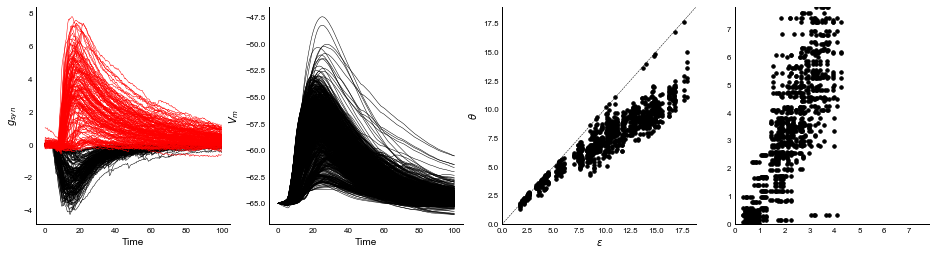

c2_EI 170510


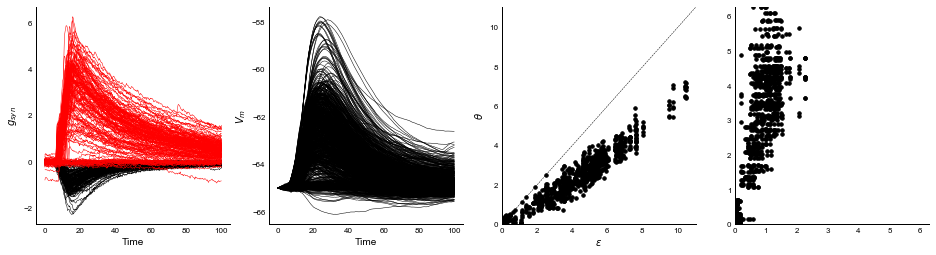

c3_EI 170524


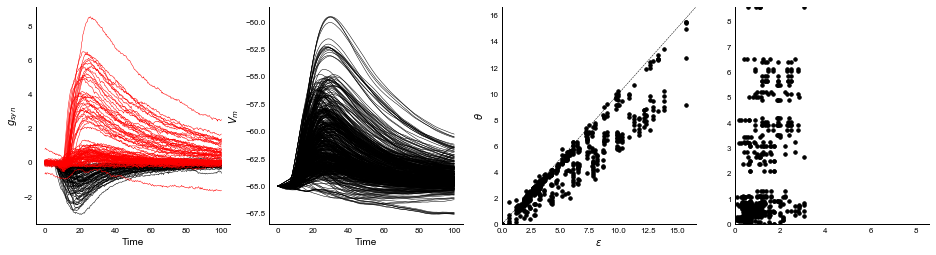

c1_EI 170524


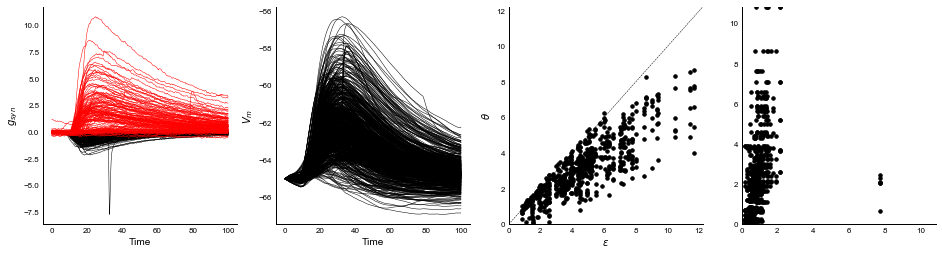

c2_EI 170530


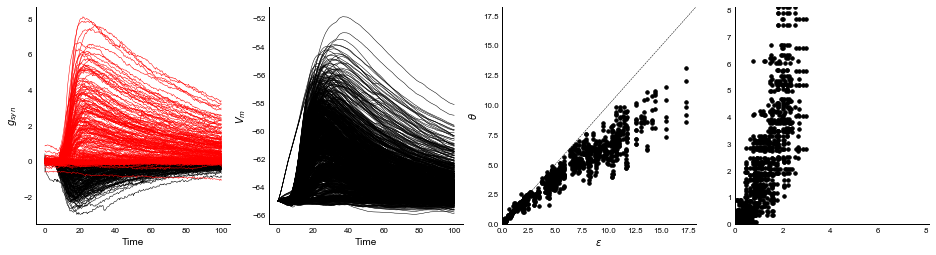

c1_EI 170530


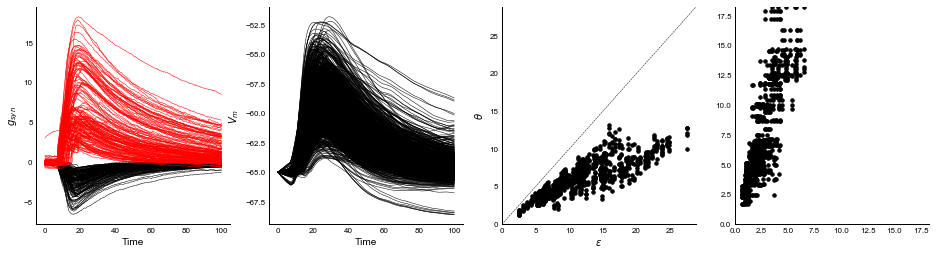

c2_EI 170531


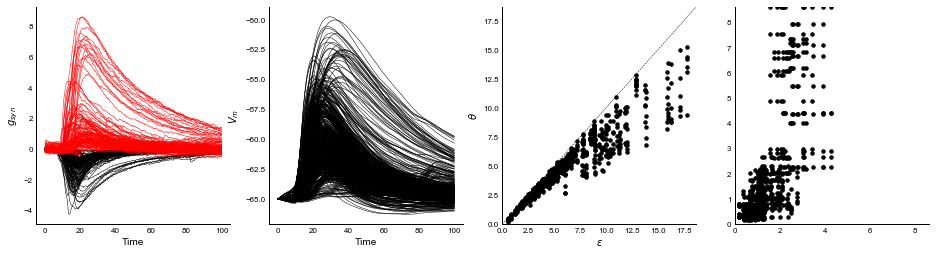

c4_EI 170531


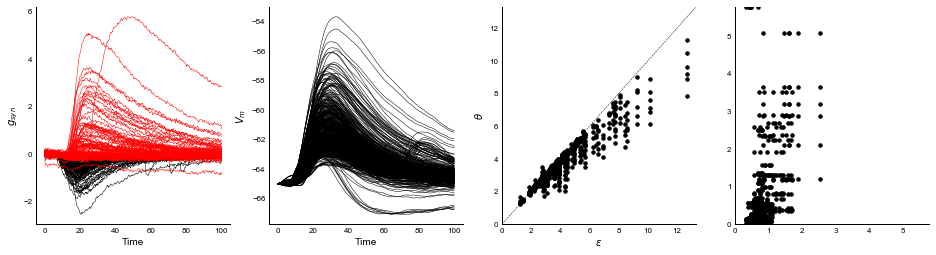

c1_EI 170531


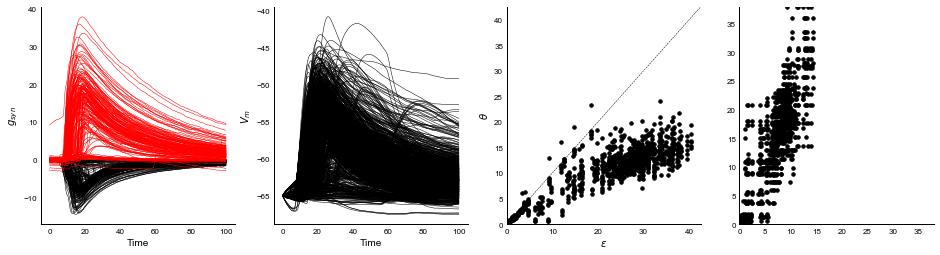

c5_EI 170720


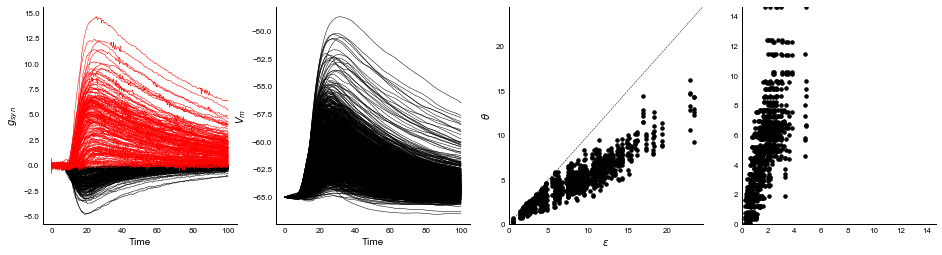

c3_EI 170720


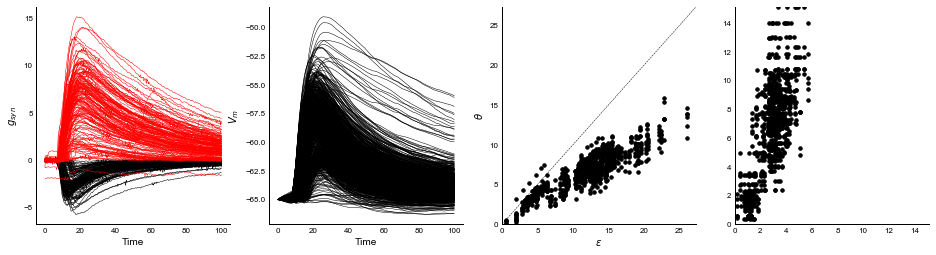

c4_EI 170720


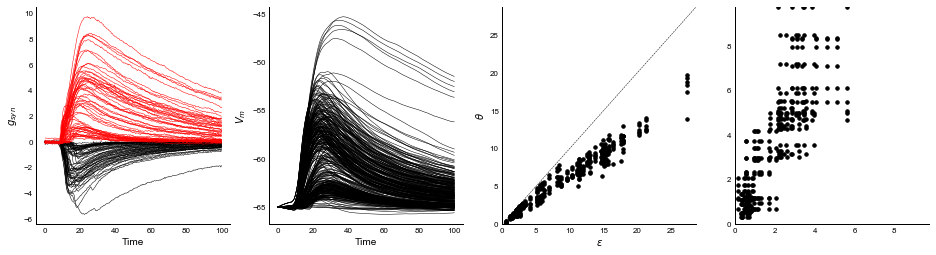

c2_EI 170720


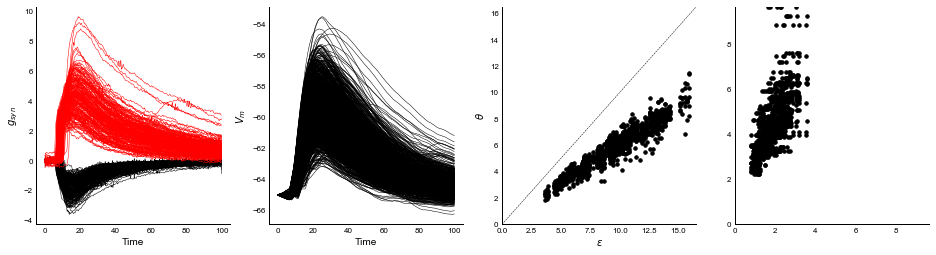

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from matplotlib import mlab
from scipy.optimize import curve_fit

feature = 1
areaScalingFactor = 1e9 # nA.ms
scalingFactor = areaScalingFactor
r_squared = []
slopes = []
valid_neurons = []
studentised_res = []
coord_sqr_all_cells = []
nanosiemens = 1e9    


k = 2.
R = 0.8

g_exc_max = 5. #nS 
tau_exc = 12. #ms
delta_exc = 0. #mS

g_inh_max = k*g_exc_max #nS
tau_inh = R*tau_exc #ms
delta_inh = 3. #ms

# Cell parameters
g_Leak=6.25 #nS taken from data
E_leak=0. #mV taken from data
E_exc=65. #mV 
E_inh=-5. #mV
Vrest=0. #mV
Cm=100. #pF
dt = 0.05 #ms

for index, n in enumerate(neurons):
    n = neurons[index]
    print(n.index, n.date)
    obs_exc, obs_inh = {}, {}
    exc_error, inh_error = {}, {}
    del_exc, del_inh = {}, {}
    tau_exc_dict, tau_inh_dict, delta_exc_dict, delta_inh_dict, g_exc_dict, g_inh_dict = {}, {}, {}, {}, {}, {}
    ttp_exc, ttp_inh = {}, {}
    amplitude = {}
    sqrs = []
    coord_sqrs = {}

    fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4)
    for expType,expt in n:
        for sqr in expt:
            #if sqr == 1 or sqr == 2:
                if (expType == 1):
                    sqrs.append(sqr)
                    for coord in expt[sqr].coordwise:
                        trajectory = []
                        for trial in expt[sqr].coordwise[coord].trials:
                            trajectory.append(np.array(trial.interestWindow)*nanosiemens/-70)
                            t_arr = np.linspace(0,100,len(trial.interestWindow))
                            ax1.plot(t_arr, -trajectory[-1],c='k')  
                        obs_exc[coord] = list(trajectory)

                elif (expType == 2):
                    for coord in expt[sqr].coordwise:
                        trajectory = []
                        for trial in expt[sqr].coordwise[coord].trials:
                            trajectory.append(np.array(trial.interestWindow)*nanosiemens/70)
                            t_arr = np.linspace(0,100,len(trial.interestWindow))
                            ax1.plot(t_arr, trajectory[-1],c='r')  
                        obs_inh[coord] = list(trajectory)

                        
    totalTrajectory = {}
    excScale = 1
    exc_max = []
    pred_obs_max = []
    truepredTraj = {}
    truepred_exc = {}
    exc_max = []
    pred_obs_max = []
    true_exc_max = []
    true_pred_obs_max = []
    delays = []
    fit_delays = []
    nanosiemens = 1e9
    tau_exc = []
    tau_inh = []
    tau_ratio = []
    ttp_ratio = []
    ei_balance = []
    
    for coord in set(obs_exc.keys()).intersection(set(obs_inh.keys())):

        Vrest = -65
        
        count_comb = 0
        truepredTraj[coord] = []
        truepred_exc[coord] = []
        
        for pred_g_exc in obs_exc[coord]:
            for pred_g_inh in obs_inh[coord]:
                time, true_pred_obs = getVmTrace(pred_g_exc, pred_g_inh, Vrest=Vrest)
                time, true_pred_exc = getVmTrace(pred_g_exc, np.zeros(len(pred_g_exc)), Vrest=Vrest)
                ei_balance.append((max(pred_g_exc), max(pred_g_inh)))
#                 print(pred_g_inh)
#                 if ((np.average(pred_g_exc) < 0.1) or (np.average(pred_g_inh) < 0.1)):
#                     continue
                ax2.plot(time, true_pred_obs) # Depolarization upward
        
                true_pred_obs_max.append(max(true_pred_obs) - Vrest)
                true_exc_max.append(max(true_pred_exc) - Vrest)

    ax3.scatter(true_exc_max, true_pred_obs_max, s=12)
    ax3.set_xlim(xmin=0)
    ax3.set_ylim(ax3.get_xlim())
    ax3.plot([ax3.get_xlim()[0],ax3.get_xlim()[1]],[ax3.get_xlim()[0],ax3.get_xlim()[1]],'--')
    
    ax1.set_xlabel("Time")
    ax1.set_ylabel("$g_{syn}$")
    
    ax2.set_xlabel("Time")
    ax2.set_ylabel("$V_m$")

    ax3.set_xlabel("$\epsilon$")
    ax3.set_ylabel("$\\theta$")
    
    e_max, i_max = zip(*ei_balance)
    ax4.scatter(e_max, i_max, s=12)
    max_e_i = max([max(e_max), max(i_max)])
    ax4.set_xlim(xmin=0, xmax=max_e_i)
    ax4.set_ylim(ymin=0, ymax=max_e_i)
    
    simpleaxis([ax1,ax2,ax3,ax4])
    fig.set_figwidth(16)
    plt.show()

## Now taking g_max from inhibition, and scaling the excitatory conductances to that value. taus and delays can be fixed in this way to look at the effect of leak only.

In [28]:
def add_delay(g, delay, dt=0.05):
    delay_indices = int(delay/dt)
    if delay_indices:
        noise = np.array(g[:delay_indices])
        return np.concatenate([noise, g[:-delay_indices]])
    else:
        return g
    
def remove_delay(g, delay, dt=0.05):
    delay_indices = int(delay/dt)
    if delay_indices:
        noise = np.array(g[:delay_indices])
        return np.concatenate([g[delay_indices:], noise])
    else:
        return g
    
def createInhFromExc(g_exc, g_inh, delay, dt=0.05 ):
    g_ratio = np.max(g_inh)/np.max(g_exc)
    g_inh_new = g_ratio*add_delay(g_exc, delay, dt)
    return g_inh_new

c2_EI 161220


NameError: name 'delay_ei' is not defined

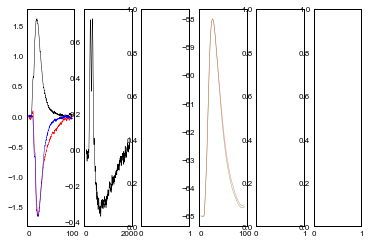

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from matplotlib import mlab
from scipy.optimize import curve_fit

feature = 1
areaScalingFactor = 1e9 # nA.ms
scalingFactor = areaScalingFactor
r_squared = []
slopes = []
valid_neurons = []
studentised_res = []
coord_sqr_all_cells = []
nanosiemens = 1e9    
k = 2.
R = 0.8

g_exc_max = 5. #nS 
tau_exc = 12. #ms
delta_exc = 0. #mS

g_inh_max = k*g_exc_max #nS
tau_inh = R*tau_exc #ms
delta_inh = 3. #ms

# Cell parameters
g_Leak=6.25 #nS taken from data
#g_Leak=3.25 #nS taken from data
E_leak=0. #mV taken from data
E_exc=65. #mV 
E_inh=-5. #mV
Vrest=0. #mV
Cm=100. #pF
dt = 0.05 #ms

for index, n in enumerate(neurons):
    n = neurons[index]
    print(n.index, n.date)
    obs_exc, obs_inh = {}, {}
    exc_error, inh_error = {}, {}
    del_exc, del_inh = {}, {}
    tau_exc_dict, tau_inh_dict, delta_exc_dict, delta_inh_dict, g_exc_dict, g_inh_dict = {}, {}, {}, {}, {}, {}
    ttp_exc, ttp_inh = {}, {}
    amplitude = {}
    sqrs = []
    coord_sqrs = {}

    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(ncols=6)
    for expType,expt in n:
        for sqr in expt:
            #if sqr == 1 or sqr == 2:
                if (expType == 1):
                    sqrs.append(sqr)
                    for coord in expt[sqr].coordwise:
                        trajectory = []
                        delays = []
                        for trial in expt[sqr].coordwise[coord].trials:
                            trajectory.append(trial.interestWindow)
                            onset = findOnsetTime(trial)
                            #onset = np.argmin(trial.interestWindow)/20.
                            if onset:
                                delays.append(onset)
                        obs_exc[coord] = np.average(trajectory,axis=0)
                        del_exc[coord] = np.nanmean(delays)
                        t_arr = np.linspace(0,100,len(obs_exc[coord]))
                        #ax1.plot(t_arr, obs_exc[coord]*nanosiemens/-70,c='r') 
                        popt, pcov = curve_fit(alphaSynapse, t_arr, obs_exc[coord]*nanosiemens/-70)
                        g_exc_dict[coord], delta_exc_dict[coord], tau_exc_dict[coord] = popt
                        ttp_exc[coord] = t_arr[np.argmax(obs_exc[coord])]
                        #ax1.plot(t_arr, alphaSynapse(t_arr, *popt), 'b-')

                elif (expType == 2):
                    for coord in expt[sqr].coordwise:
                        trajectory = []
                        delays = []
                        for trial in expt[sqr].coordwise[coord].trials:
                            trajectory.append(trial.interestWindow)
                            onset = findOnsetTime(trial)
                            #onset = np.argmax(trial.interestWindow)/20.
                            if onset:
                                delays.append(onset)
                        obs_inh[coord] = np.average(trajectory,axis=0)
                        del_inh[coord] = np.average(delays)
                        t_arr = np.linspace(0,100,len(obs_inh[coord]))
                        #ax1.plot(t_arr, obs_inh[coord]*nanosiemens/-70)
                        popt, pcov = curve_fit(alphaSynapse, t_arr, obs_inh[coord]*nanosiemens/-70)
                        g_inh_dict[coord], delta_inh_dict[coord], tau_inh_dict[coord] = popt
                        ttp_inh[coord] = t_arr[np.argmax(obs_inh[coord])]
                        #ax1.plot(t_arr, alphaSynapse(t_arr, *popt), 'b-')
                        
    totalTrajectory = {}
    excScale = 1
    exc_max = []
    pred_obs_max = []
    truepredTraj = {}
    exc_predTraj = {}
    truepred_exc = {}
    exc_max = []
    pred_obs_max = []
    true_exc_max = []
    true_pred_obs_max = []
    exc_pred_obs_max = []
    delays = []
    fit_delays = []
    nanosiemens = 1e9
    tau_exc = []
    tau_inh = []
    tau_ratio = []
    ttp_ratio = []
    ie_ratio = []
    kinetic_error = []
        
    for coord in set(obs_exc.keys()).intersection(set(obs_inh.keys())):
        delay = 3 # ms
        if (not np.isnan(delay)) and (delay>0.1):
            totalTrajectory[coord] = excScale*obs_exc[coord]*nanosiemens/-70 + obs_inh[coord]*nanosiemens/-70
            #print (np.average(pred_g_exc))
            #truepredTraj[coord] = (1/Cm)*(g_leak*(Vm-E_leak) + pred_g_exc*(Vm-E_exc) + pred_g_inh*(Vm-E_inh))
            #print (truepredTraj[coord])
            ax2.plot(totalTrajectory[coord]) # Depolarization upward
            exc_max.append(max(obs_exc[coord]*nanosiemens/-70))
            pred_obs_max.append(max(totalTrajectory[coord]))

            # Now for true(er) predictions
            pred_g_exc = (obs_exc[coord]/-70)*nanosiemens
            pred_g_inh = (obs_inh[coord]/70)*nanosiemens
            pred_g_inh_exc = createInhFromExc(pred_g_exc, pred_g_inh, delay)

            ax1.plot(t_arr, pred_g_exc, c='k')
            ax1.plot(t_arr, -pred_g_inh, c='r')
            ax1.plot(t_arr, -pred_g_inh_exc, c='b')

            Vrest = -65
            time, exc_predTraj[coord] = getVmTrace(pred_g_exc, pred_g_inh_exc, Vrest=Vrest)
            time, truepredTraj[coord] = getVmTrace(pred_g_exc, pred_g_inh, Vrest=Vrest)
            time, truepred_exc[coord] = getVmTrace(pred_g_exc, np.zeros(len(pred_g_exc)), Vrest=Vrest)

            kinetic_error.append(np.max(exc_predTraj[coord]) - np.max(truepredTraj[coord]))
            ie_ratio.append(np.max(pred_g_inh)/np.max(pred_g_exc))

            ax4.plot(time, truepredTraj[coord], alpha=0.5, c='g') # Depolarization upward
            ax4.plot(time, exc_predTraj[coord], alpha=0.5, c='r') # Depolarization upward

            true_exc_max.append(max(truepred_exc[coord]) - Vrest)
            true_pred_obs_max.append(max(truepredTraj[coord]) - Vrest)
            exc_pred_obs_max.append(max(exc_predTraj[coord]) - Vrest)

            delays.append(delay_ei[coord])
            fit_delays.append(delta_inh_dict[coord] - delta_exc_dict[coord])

            tau_ratio.append(tau_inh_dict[coord]/tau_exc_dict[coord])
            ttp_ratio.append(ttp_inh[coord]/ttp_exc[coord])
            tau_exc.append(tau_exc_dict[coord])
            tau_inh.append(tau_inh_dict[coord])

    ax3.scatter(exc_max, pred_obs_max)
    ax5.scatter(true_exc_max, true_pred_obs_max, alpha=0.5, c='g', s=8)
    ax5.scatter(true_exc_max, exc_pred_obs_max, alpha=0.5, c='r', s=8)
    ax6.scatter(exc_max, delays)
    
    ax3.set_xlim(xmin=0.)
    ax3.set_ylim(ax3.get_xlim())
    
    ax5.set_xlim(xmin=0)
    ax5.set_ylim(ax5.get_xlim())
    ax5.plot([ax5.get_xlim()[0],ax5.get_xlim()[1]],[ax5.get_xlim()[0],ax5.get_xlim()[1]],'--')
    
    ax1.set_xlabel("Time")
    ax1.set_ylabel("$g_{syn}$")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("$g_{syn}$")
    
    ax4.set_xlabel("Time")
    ax4.set_ylabel("$V_m$")

    ax5.set_xlabel("$\epsilon$")
    ax5.set_ylabel("$\\theta$")
    
    simpleaxis([ax1,ax2,ax3,ax4,ax5,ax6])
    fig.set_figwidth(24)
    plt.show()
    
    plt.hist(tau_ratio)
    plt.show()
    
    plt.hist( [j for j in ttp_ratio if not np.isinf(j)])
    plt.show()
    
    plt.scatter(exc_max, ttp_ratio)
    plt.show()
    
    plt.scatter(tau_exc, tau_ratio)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.scatter(ie_ratio, kinetic_error)
    ax.set_xlabel("I/E ratio")
    ax.set_ylabel("$\Delta V_{max}$")
    simpleaxis(ax)
    plt.show()

    print (np.mean(tau_ratio))
    print(np.mean(tau_exc))
    print(np.mean(tau_inh))

### Now changing delays for the inhibition case and comparing it to the case with correct delays.

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from matplotlib import mlab
from scipy.optimize import curve_fit

feature = 1
areaScalingFactor = 1e9 # nA.ms
scalingFactor = areaScalingFactor
r_squared = []
slopes = []
valid_neurons = []
studentised_res = []
coord_sqr_all_cells = []
nanosiemens = 1e9    
k = 2.
R = 0.8

g_exc_max = 5. #nS 
tau_exc = 12. #ms
delta_exc = 0. #mS

g_inh_max = k*g_exc_max #nS
tau_inh = R*tau_exc #ms
delta_inh = 3. #ms

# Cell parameters
g_Leak=6.25 #nS taken from data
g_Leak=4 #nS taken from data (max)
E_leak=0. #mV taken from data
E_exc=65. #mV 
E_inh=-5. #mV
Vrest=0. #mV
Cm=100. #pF
dt = 0.05 #ms

currentThreshold = 20e-12 # pA

for index, n in enumerate(neurons):
    n = neurons[index]
    print(n.index, n.date)
    obs_exc, obs_inh = {}, {}
    exc_error, inh_error = {}, {}
    del_exc, del_inh = {}, {}
    tau_exc_dict, tau_inh_dict, delta_exc_dict, delta_inh_dict, g_exc_dict, g_inh_dict = {}, {}, {}, {}, {}, {}
    ttp_exc, ttp_inh = {}, {}
    amplitude = {}
    sqrs = []
    coord_sqrs = {}

    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(ncols=6)
    for expType,expt in n:
        for sqr in expt:
            #if sqr == 1 or sqr == 2:
                if (expType == 1):
                    sqrs.append(sqr)
                    for coord in expt[sqr].coordwise:
                        trajectory = []
                        delays = []
                        for trial in expt[sqr].coordwise[coord].trials:
                            if np.max(-trial.interestWindow) > currentThreshold:
                                trajectory.append(trial.interestWindow)
                                #onset = findOnsetTime(trial)
                                onset = findOnsetTimeThreshold(trial, expType, currentThreshold)
                                #onset = np.argmax(trial.interestWindow)/20.
                                if onset > 0:
#                                     print(onset)
                                    delays.append(onset)
                        obs_exc[coord] = np.average(trajectory,axis=0)
                        del_exc[coord] = np.nanmean(delays)
                        t_arr = np.linspace(0,100,len(obs_exc[coord]))
                        #ax1.plot(t_arr, obs_exc[coord]*nanosiemens/-70,c='r') 
                        popt, pcov = curve_fit(alphaSynapse, t_arr, obs_exc[coord]*nanosiemens/-70)
                        g_exc_dict[coord], delta_exc_dict[coord], tau_exc_dict[coord] = popt
                        ttp_exc[coord] = t_arr[np.argmax(obs_exc[coord])]
                        #ax1.plot(t_arr, alphaSynapse(t_arr, *popt), 'b-')

                elif (expType == 2):
                    for coord in expt[sqr].coordwise:
                        trajectory = []
                        delays = []
                        for trial in expt[sqr].coordwise[coord].trials:
                            if np.max(trial.interestWindow) > currentThreshold:
                                trajectory.append(trial.interestWindow)
                                #onset = findOnsetTime(trial)
                                #onset = np.argmax(trial.interestWindow)/20.
                                onset = findOnsetTimeThreshold(trial, expType, currentThreshold)
                                if onset > 0:
#                                     print(onset)
                                    delays.append(onset)
                        obs_inh[coord] = np.average(trajectory,axis=0)
                        del_inh[coord] = np.average(delays)
                        t_arr = np.linspace(0,100,len(obs_inh[coord]))
                        #ax1.plot(t_arr, obs_inh[coord]*nanosiemens/-70)
                        popt, pcov = curve_fit(alphaSynapse, t_arr, obs_inh[coord]*nanosiemens/-70)
                        g_inh_dict[coord], delta_inh_dict[coord], tau_inh_dict[coord] = popt
                        ttp_inh[coord] = t_arr[np.argmax(obs_inh[coord])]
                        #ax1.plot(t_arr, alphaSynapse(t_arr, *popt), 'b-')
                        
    totalTrajectory = {}
    excScale = 1
    exc_max = []
    pred_obs_max = []
    truepredTraj = {}
    exc_predTraj = {}
    truepred_exc = {}
    exc_max = []
    pred_obs_max = []
    true_exc_max = []
    true_pred_obs_max = []
    exc_pred_obs_max = []
    std_exc_pred_obs_max = []
    delays = []
    fit_delays = []
    nanosiemens = 1e9
    tau_exc = []
    tau_inh = []
    tau_ratio = []
    ttp_ratio = []
    Vrest = -65    
    randRepeats = 30
    
    delay_ei = {}
    delay_ei_shuffled = []
    
    commonCoords = set(obs_exc.keys()).intersection(set(obs_inh.keys()))
    for coord in commonCoords:
        delay_ei[coord] = del_inh[coord] - del_exc[coord]
        delays.append(del_inh[coord] - del_exc[coord])
        
        pred_g_exc = (obs_exc[coord]/-70)*nanosiemens
        pred_g_inh = (obs_inh[coord]/70)*nanosiemens
        
        exc_max.append(max(pred_g_exc))
        ax1.plot(t_arr, pred_g_exc, c='k')
        ax1.plot(t_arr, -pred_g_inh, c='r')
        
        time, truepredTraj[coord] = getVmTrace(pred_g_exc, pred_g_inh, Vrest=Vrest)
        time, truepred_exc[coord] = getVmTrace(pred_g_exc, np.zeros(len(pred_g_exc)), Vrest=Vrest)
        ax4.plot(time, truepredTraj[coord], alpha=0.5, c='g') # Depolarization upward 
        
        true_exc_max.append(max(truepred_exc[coord]) - Vrest)
        true_pred_obs_max.append(max(truepredTraj[coord]) - Vrest)
        
        
    for i in range(randRepeats):
        shuffled_delays = np.random.permutation(delay_ei.values())
        delay_ei_shuffled.append({key:np.float(shuffled_delays[j]) for j, key in enumerate(delay_ei.keys())})
        
    for coord in commonCoords:
        pred_g_exc = (obs_exc[coord]/-70)*nanosiemens
        pred_g_inh = (obs_inh[coord]/70)*nanosiemens
        true_delay = delay_ei[coord]
        shuffled_delay_Vmax = []
        for rep in range(randRepeats):
            shuff_delay = delay_ei_shuffled[rep][coord] # ms
            diff_delay = shuff_delay - true_delay

            if not np.isnan(diff_delay):

                if diff_delay < 0:
                    pred_g_inh_exc = remove_delay(pred_g_inh, -diff_delay) # The delay removed inhibition
                elif diff_delay >0:
                    pred_g_inh_exc = add_delay(pred_g_inh, diff_delay) # The delay removed inhibition
                else:
#                     print ("Randomized delay and true delay the same: {}, {}".format(true_delay, shuff_delay))
                    pred_g_inh_exc = np.array([i for i in pred_g_inh])

                time, shuffledVm_trial = getVmTrace(pred_g_exc, pred_g_inh_exc, Vrest=Vrest)
                shuffled_delay_Vmax.append(np.max(shuffledVm_trial) - Vrest)
        exc_pred_obs_max.append(np.nanmean(shuffled_delay_Vmax))
        std_exc_pred_obs_max.append(np.nanstd(shuffled_delay_Vmax, ddof=1))

    ax5.plot(true_exc_max, true_pred_obs_max, 'o', alpha=0.5, c='g', markersize=5)
    ax5.errorbar(true_exc_max, exc_pred_obs_max, alpha=0.5, c='r', yerr=std_exc_pred_obs_max, fmt='o', markersize=5)
    ax6.scatter(exc_max, delays)
    
    ax3.set_xlim(xmin=0.)
    ax3.set_ylim(ax3.get_xlim())
    
    ax5.set_xlim(xmin=0)
    ax5.set_ylim(ax5.get_xlim())
    ax5.plot([ax5.get_xlim()[0],ax5.get_xlim()[1]],[ax5.get_xlim()[0],ax5.get_xlim()[1]],'--')
    
    ax1.set_xlabel("Time")
    ax1.set_ylabel("$g_{syn}$")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("$g_{syn}$")
    
    ax4.set_xlabel("Time")
    ax4.set_ylabel("$V_m$")

    ax5.set_xlabel("$\epsilon$")
    ax5.set_ylabel("$\\theta$")
    
    simpleaxis([ax1,ax2,ax3,ax4,ax5,ax6])
    fig.set_figwidth(24)
    plt.show()

## Multiple I/E ratios

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from matplotlib import mlab
from scipy.optimize import curve_fit

feature = 1
areaScalingFactor = 1e9 # nA.ms
scalingFactor = areaScalingFactor
r_squared = []
slopes = []
valid_neurons = []
studentised_res = []
coord_sqr_all_cells = []
nanosiemens = 1e9    
k = 2.
R = 0.8

g_exc_max = 5. #nS 
tau_exc = 12. #ms
delta_exc = 0. #mS

g_inh_max = k*g_exc_max #nS
tau_inh = R*tau_exc #ms
delta_inh = 3. #ms

# Cell parameters
g_Leak=6.25 #nS taken from data
g_Leak=4 #nS taken from data (max)
E_leak=0. #mV taken from data
E_exc=65. #mV 
E_inh=-5. #mV
Vrest=0. #mV
Cm=100. #pF
dt = 0.05 #ms

currentThreshold = 20e-12 # pA

for index, n in enumerate(neurons):
    n = neurons[index]
    print(n.index, n.date)
    obs_exc, obs_inh = {}, {}
    exc_error, inh_error = {}, {}
    del_exc, del_inh = {}, {}
    tau_exc_dict, tau_inh_dict, delta_exc_dict, delta_inh_dict, g_exc_dict, g_inh_dict = {}, {}, {}, {}, {}, {}
    ttp_exc, ttp_inh = {}, {}
    amplitude = {}
    sqrs = []
    coord_sqrs = {}

    fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(ncols=4,nrows=2)
    for expType,expt in n:
        for sqr in expt:
            #if sqr == 1 or sqr == 2:
                if (expType == 1):
                    sqrs.append(sqr)
                    for coord in expt[sqr].coordwise:
                        trajectory = []
                        delays = []
                        for trial in expt[sqr].coordwise[coord].trials:
                            if np.max(-trial.interestWindow) > currentThreshold:
                                trajectory.append(trial.interestWindow)
                                #onset = findOnsetTime(trial)
                                #onset = findOnsetTimeThreshold(trial, expType, currentThreshold)
                                #onset = np.argmax(trial.interestWindow)/20.
                                #if onset > 0:
#                                     print(onset)
                                #    delays.append(onset)
                        obs_exc[coord] = np.average(trajectory,axis=0)
                        #del_exc[coord] = np.nanmean(delays)
                        t_arr = np.linspace(0,100,len(obs_exc[coord]))
                        #ax1.plot(t_arr, obs_exc[coord]*nanosiemens/-70,c='r') 
                        popt, pcov = curve_fit(alphaSynapse, t_arr, obs_exc[coord]*nanosiemens/-70)
                        g_exc_dict[coord], delta_exc_dict[coord], tau_exc_dict[coord] = popt
                        ttp_exc[coord] = t_arr[np.argmax(obs_exc[coord])]
                        #ax1.plot(t_arr, alphaSynapse(t_arr, *popt), 'b-')

                elif (expType == 2):
                    for coord in expt[sqr].coordwise:
                        trajectory = []
                        delays = []
                        for trial in expt[sqr].coordwise[coord].trials:
                            if np.max(trial.interestWindow) > currentThreshold:
                                trajectory.append(trial.interestWindow)
                                #onset = findOnsetTime(trial)
                                #onset = np.argmax(trial.interestWindow)/20.
                                #onset = findOnsetTimeThreshold(trial, expType, currentThreshold)
                                #if onset > 0:
#                                     print(onset)
                                #    delays.append(onset)
                        obs_inh[coord] = np.average(trajectory,axis=0)
                        #del_inh[coord] = np.average(delays)
                        t_arr = np.linspace(0,100,len(obs_inh[coord]))
                        #ax1.plot(t_arr, obs_inh[coord]*nanosiemens/-70)
                        popt, pcov = curve_fit(alphaSynapse, t_arr, obs_inh[coord]*nanosiemens/-70)
                        g_inh_dict[coord], delta_inh_dict[coord], tau_inh_dict[coord] = popt
                        ttp_inh[coord] = t_arr[np.argmax(obs_inh[coord])]
                        #ax1.plot(t_arr, alphaSynapse(t_arr, *popt), 'b-')
                        
    totalTrajectory = {}
    excScale = 1
    exc_max = []
    pred_obs_max = []
    truepredTraj = {}
    exc_predTraj = {}
    truepred_exc = {}
    exc_max = []
    pred_obs_max = []
    true_exc_max = []
    true_pred_obs_max = []
    exc_pred_obs_max = []
    std_exc_pred_obs_max = []
    delays = []
    fit_delays = []
    nanosiemens = 1e9
    tau_exc = []
    tau_inh = []
    tau_ratio = []
    ttp_ratio = []
    Vrest = -65    
    randRepeats = 30
    
    delay_ei = {}
    delay_ei_shuffled = []
    
    commonCoords = set(obs_exc.keys()).intersection(set(obs_inh.keys()))
    
    minT, maxT = 5, 30 # ms to plot traces
    minT_index, maxT_index = minT*20, maxT*20
    
    # With delays intact 
    for coord in commonCoords:
     
        pred_g_exc = (obs_exc[coord]/-70)*nanosiemens
        pred_g_inh = (obs_inh[coord]/70)*nanosiemens

        del_exc[coord] = findOnsetTime_trace(pred_g_exc)
        del_inh[coord] = findOnsetTime_trace(pred_g_inh)
        
        if not np.isnan(del_exc[coord]) and not np.isnan(del_inh[coord]):
            delay_ei[coord] = del_inh[coord] - del_exc[coord]
            delays.append(del_inh[coord] - del_exc[coord])

            exc_max.append(max(pred_g_exc))
            ax1.plot(t_arr[minT_index:maxT_index], pred_g_exc[minT_index:maxT_index], c='k')
            ax1.plot(t_arr[int(del_exc[coord]*20)], pred_g_exc[int(del_exc[coord]*20)], c='k', markersize=12)

            ax1.plot(t_arr[minT_index:maxT_index], -pred_g_inh[minT_index:maxT_index], c='r')
            ax1.plot(t_arr[int(del_inh[coord]*20)], pred_g_inh[int(del_inh[coord]*20)], c='r', markersize=12)

            time, truepredTraj[coord] = getVmTrace(pred_g_exc, pred_g_inh, Vrest=Vrest)
            time, truepred_exc[coord] = getVmTrace(pred_g_exc, np.zeros(len(pred_g_exc)), Vrest=Vrest)
            ax2.plot(time, truepredTraj[coord], alpha=0.5, c='g') # Depolarization upward 

            true_exc_max.append(max(truepred_exc[coord]) - Vrest)
            true_pred_obs_max.append(max(truepredTraj[coord]) - Vrest)
    ax3.plot(true_exc_max, true_pred_obs_max, 'o', alpha=0.5, c='g', markersize=5)
    
    ie_ratios = [0.375, 0.75, 1.5, 3]
    colorArr = ['blue', 'red', 'orange', 'purple']

    for j, rho in enumerate(ie_ratios):
        exc_pred_obs_max = []
        true_exc_max = []
        for coord in delay_ei:
            #newRatio_delay_Vmax = []

            pred_g_exc = (obs_exc[coord]/-70)*nanosiemens
            pred_g_inh = (rho*obs_inh[coord]/70)*nanosiemens
            true_delay = delay_ei[coord]

            time, newRatio_Vm_trial = getVmTrace(pred_g_exc, pred_g_inh, Vrest=Vrest)
            #time, exc_volt = getVmTrace(pred_g_exc, np.zeros(len(pred_g_exc)), Vrest=Vrest)
            #newRatio_delay_Vmax.append(np.max(newRatio_Vm_trial) - Vrest)
            true_exc_max.append(max(truepred_exc[coord]) - Vrest)
            exc_pred_obs_max.append(np.max(newRatio_Vm_trial) - Vrest)
        ax3.plot(true_exc_max, exc_pred_obs_max, 'o', alpha=0.5, c=colorArr[j], markersize=5)
        
    
    ax4.scatter(exc_max, delays)
    
    ax3.set_xlim(xmin=0.)
    ax3.set_ylim(ax3.get_xlim())
    
    ax3.set_xlim(xmin=0)
    ax3.set_ylim(ax3.get_xlim())
    ax3.plot([ax3.get_xlim()[0],ax3.get_xlim()[1]],[ax3.get_xlim()[0],ax3.get_xlim()[1]],'--')
    
    ax1.set_xlabel("Time")
    ax1.set_ylabel("$g_{syn}$")
    
    ax2.set_xlabel("Time")
    ax2.set_ylabel("$V_m$")

    ax3.set_xlabel("$\epsilon$")
    ax3.set_ylabel("$\\theta$")
    
    ax4.set_xlabel("$g_{exc}$")
    ax4.set_ylabel("$\\delta_{inh}$")
    ax4.set_ylim(-3, 20)
    
    # With constant delays
    
    constant_delay = 2 # ms
    
    pred_inh_constant_delay = {}
    
    true_exc_max = []
    true_pred_obs_max = []
    delay_corrected = []
    del_inh_exc = {}
    
    for coord in delay_ei:
        
        pred_g_exc = (obs_exc[coord]/-70)*nanosiemens
        pred_g_inh = (obs_inh[coord]/70)*nanosiemens
      
        diff_delay = constant_delay - delay_ei[coord]
        
        if not np.isnan(delay_ei[coord]):
        
            if diff_delay < 0:
                pred_g_inh_exc = remove_delay(pred_g_inh, -diff_delay) # The delay removed inhibition
            elif diff_delay >0:
                pred_g_inh_exc = add_delay(pred_g_inh, diff_delay) # The delay removed inhibition
            else:
                pred_g_inh_exc = np.array([i for i in pred_g_inh])
            
            del_inh_exc[coord] = findOnsetTime_trace(pred_g_inh_exc)
            delay_corrected.append(del_inh_exc[coord])
            
            ax5.plot(t_arr[minT_index:maxT_index], pred_g_exc[minT_index:maxT_index], c='k')
            ax5.plot(t_arr[minT_index:maxT_index], -pred_g_inh_exc[minT_index:maxT_index], c='r')

            time, truepredTraj[coord] = getVmTrace(pred_g_exc, pred_g_inh_exc, Vrest=Vrest)
            #time, truepred_exc[coord] = getVmTrace(pred_g_exc, np.zeros(len(pred_g_exc)), Vrest=Vrest)
            ax6.plot(time, truepredTraj[coord], alpha=0.5, c='g') # Depolarization upward 

            true_exc_max.append(max(truepred_exc[coord]) - Vrest)
            true_pred_obs_max.append(max(truepredTraj[coord]) - Vrest)
        
            pred_inh_constant_delay[coord] = pred_g_inh_exc
            
    ax7.plot(true_exc_max, true_pred_obs_max, 'o', alpha=0.5, c='g', markersize=5)
    
    
        
    ie_ratios = [0.375, 0.75, 1.5, 3]
    colorArr = ['blue', 'red', 'orange', 'purple']
    
    
    for j, rho in enumerate(ie_ratios):
        exc_pred_obs_max = []
        exc_max = []
        true_exc_max = []
        
        for coord in del_inh_exc:
            pred_g_exc = (obs_exc[coord]/-70)*nanosiemens
            exc_max.append(np.max(pred_g_exc))
    
            #newRatio_delay_Vmax = []
            pred_g_inh = rho*pred_inh_constant_delay[coord]

            time, newRatio_Vm_trial = getVmTrace(pred_g_exc, pred_g_inh, Vrest=Vrest)
            #newRatio_delay_Vmax.append(np.max(newRatio_Vm_trial) - Vrest)
            true_exc_max.append(max(truepred_exc[coord]) - Vrest)
            exc_pred_obs_max.append(np.max(newRatio_Vm_trial) - Vrest)
        ax7.plot(true_exc_max, exc_pred_obs_max, 'o', alpha=0.5, c=colorArr[j], markersize=5)
        
    
    ax8.scatter(exc_max, delay_corrected)
    
    ax7.set_xlim(xmin=0.)
    ax7.set_ylim(ax7.get_xlim())
    
    ax7.set_xlim(xmin=0)
    ax7.set_ylim(ax7.get_xlim())
    ax7.plot([ax7.get_xlim()[0],ax7.get_xlim()[1]],[ax7.get_xlim()[0],ax7.get_xlim()[1]],'--')
    
    ax5.set_xlabel("Time")
    ax5.set_ylabel("$g_{syn}$")
    
    ax6.set_xlabel("Time")
    ax6.set_ylabel("$V_m$")

    ax7.set_xlabel("$\epsilon$")
    ax7.set_ylabel("$\\theta$")
    
    ax8.set_xlabel("$g_{exc}$")
    ax8.set_ylabel("$\\delta_{inh}$")
    ax8.set_ylim(-3, 20)
    
    simpleaxis([ax1,ax2,ax3,ax4, ax5, ax6, ax7, ax8])
    fig.set_figwidth(16)
    fig.set_figheight(8)
    plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from matplotlib import mlab
from scipy.optimize import curve_fit

feature = 1
areaScalingFactor = 1e9 # nA.ms
scalingFactor = areaScalingFactor
r_squared = []
slopes = []
valid_neurons = []
studentised_res = []
coord_sqr_all_cells = []
nanosiemens = 1e9    


k = 2.
R = 0.8

g_exc_max = 5. #nS 
tau_exc = 12. #ms
delta_exc = 0. #mS

g_inh_max = k*g_exc_max #nS
tau_inh = R*tau_exc #ms
delta_inh = 3. #ms

# Cell parameters
g_Leak=6.25 #nS taken from data
E_leak=0. #mV taken from data
E_exc=65. #mV 
E_inh=-5. #mV
Vrest=0. #mV
Cm=100. #pF
dt = 0.05 #ms
millisecond = 1e3

for index, n in enumerate(neurons):
    n = neurons[index]
    print(n.index, n.date)
    obs_exc, obs_inh = {}, {}
    exc_error, inh_error = {}, {}
    del_exc, del_inh = {}, {}
    tau_exc_dict, tau_inh_dict, delta_exc_dict, delta_inh_dict, g_exc_dict, g_inh_dict = {}, {}, {}, {}, {}, {}
    ttp_exc, ttp_inh = {}, {}
    amplitude = {}
    sqrs = []
    coord_sqrs = {}

    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(ncols=3,nrows=2)
    for expType,expt in n:
        for sqr in expt:
            #if sqr == 1 or sqr == 2:
                if (expType == 1):
                    sqrs.append(sqr)
                    for coord in expt[sqr].coordwise:
                        trajectory = []
                        del_exc[coord] = []
                        for trial in expt[sqr].coordwise[coord].trials:
                            trajectory.append(np.array(trial.interestWindow)*nanosiemens/-70)
                            t_arr = np.linspace(0,100,len(trial.interestWindow))
                            del_exc[coord].append(findOnsetTime(trial))
                            ax1.plot(t_arr, -trajectory[-1],c='k')  
                        obs_exc[coord] = list(trajectory)

                elif (expType == 2):
                    for coord in expt[sqr].coordwise:
                        trajectory = []
                        del_inh[coord] = []
                        for trial in expt[sqr].coordwise[coord].trials:
                            trajectory.append(np.array(trial.interestWindow)*nanosiemens/70)
                            t_arr = np.linspace(0,100,len(trial.interestWindow))
                            del_inh[coord].append(findOnsetTime(trial))
                            ax1.plot(t_arr, trajectory[-1],c='r')  
                        obs_inh[coord] = list(trajectory)

                        
    totalTrajectory = {}
    excScale = 1
    exc_max = []
    pred_obs_max = []
    truepredTraj = {}
    truepred_exc = {}
    exc_max = []
    pred_obs_max = []

    delays = []
    fit_delays = []
    nanosiemens = 1e9
    tau_exc = []
    tau_inh = []
    tau_ratio = []
    ttp_ratio = []
    ei_balance = []
    
    
    true_exc_max = []
    true_pred_obs_max = []
    std_true_exc_max = []
    std_true_pred_obs_max = []
    ei_onset_delay = {}
    std_ei_onset_delay = {}
    exc_onset={}
    inh_onset={}
    
    
    ie_ratios = [0.375, 0.75, 1, 1.5, 3]
    colorArr = ['blue', 'red', 'k', 'orange', 'purple']
    for k,ie_ratio in enumerate(ie_ratios):
        true_exc_max = []
        true_pred_obs_max = []
        std_true_exc_max = []
        std_true_pred_obs_max = []
        ei_onset_delay = []
        std_ei_onset_delay = []
        for coord in set(obs_exc.keys()).intersection(set(obs_inh.keys())):

            Vrest = -65

            count_comb = 0
            truepredTraj[coord] = []
            truepred_exc[coord] = []

            trial_delay_onset = []
            for i, pred_g_exc in enumerate(obs_exc[coord]):

                time, true_pred_exc = getVmTrace(pred_g_exc, np.zeros(len(pred_g_exc)), Vrest=Vrest)
                trial_exc_onset = del_exc[coord][i]
                truepred_exc[coord].append(max(true_pred_exc) - Vrest)

                for j, pred_g_inh in enumerate(obs_inh[coord]):
                    time, true_pred_obs = getVmTrace(pred_g_exc, ie_ratio*pred_g_inh, Vrest=Vrest)
                    trial_inh_onset = del_inh[coord][j]
                    truepredTraj[coord].append(max(true_pred_obs) - Vrest)
                    
                    if trial_exc_onset and trial_inh_onset and not np.isnan(trial_exc_onset) and not np.isnan(trial_inh_onset):
                        trial_delay_onset.append((trial_inh_onset - trial_exc_onset)*millisecond)


            ei_onset_delay.append(np.nanmean(trial_delay_onset))
            std_ei_onset_delay.append(np.nanstd(trial_delay_onset,ddof=1))
            
            true_pred_obs_max.append(np.average(truepredTraj[coord]))
            true_exc_max.append(np.average(truepred_exc[coord]))
            
            std_true_pred_obs_max.append(np.std(truepredTraj[coord],ddof=1))
            std_true_exc_max.append(np.std(truepred_exc[coord],ddof=1))

        ax2.errorbar(true_exc_max, true_pred_obs_max, xerr=std_true_exc_max, yerr=std_true_pred_obs_max, fmt='o', c=colorArr[k], markersize=6)
        ax2.set_xlim(xmin=0)
        ax2.set_ylim(ax2.get_xlim())
        ax2.plot([ax2.get_xlim()[0],ax2.get_xlim()[1]],[ax2.get_xlim()[0],ax2.get_xlim()[1]],'--')
    
    ax3.errorbar(true_exc_max, ei_onset_delay, yerr=std_ei_onset_delay, xerr=std_true_exc_max, fmt='o', markersize=6)
    ax1.set_xlabel("Time")
    ax1.set_ylabel("$g_{syn}$")
    
    ax2.set_xlabel("Time")
    ax2.set_ylabel("$V_m$")

    ax3.set_xlabel("$\epsilon$")
    ax3.set_ylabel("$\\delta_{inh}$")
    
    # Snapping delays 
    
    totalTrajectory = {}
    excScale = 1
    exc_max = []
    pred_obs_max = []
    truepredTraj = {}
    truepred_exc = {}
    exc_max = []
    pred_obs_max = []

    delays = []
    fit_delays = []
    nanosiemens = 1e9
    tau_exc = []
    tau_inh = []
    tau_ratio = []
    ttp_ratio = []
    ei_balance = []
    
    
    true_exc_max = []
    true_pred_obs_max = []
    std_true_exc_max = []
    std_true_pred_obs_max = []
    #ei_onset_delay_constant = {}
    std_ei_onset_delay = {}
    exc_onset={}
    inh_onset={}

    
    constant_delay = 2 #ms
    
    obs_inh_nodelay = {}
    del_inh_nodelay = {}
    for coord in set(obs_exc.keys()).intersection(set(obs_inh.keys())):
        obs_inh_nodelay[coord] = []
        for i, pred_g_exc in enumerate(obs_exc[coord]):
            trial_exc_onset = del_exc[coord][i]
            
            obs_inh_nodelay[coord] = []
            del_inh_nodelay[coord] = []
            for j, pred_g_inh in enumerate(obs_inh[coord]):

                trial_inh_onset = del_inh[coord][j]
                
                obs_inh_nodelay[coord].append(None)
                del_inh_nodelay[coord].append(None)
                if trial_exc_onset and trial_inh_onset and not np.isnan(trial_exc_onset) and not np.isnan(trial_inh_onset):

                    trial_ei_delay = (trial_inh_onset - trial_exc_onset)*millisecond

                    diff_delay = constant_delay - trial_ei_delay

                    if diff_delay < 0:
                        pred_g_inh_exc = remove_delay(pred_g_inh, -diff_delay) # The delay removed inhibition
                    elif diff_delay >0:
                        pred_g_inh_exc = add_delay(pred_g_inh, diff_delay) # The delay removed inhibition                       
                    else:
                        pred_g_inh_exc = np.array([i for i in pred_g_inh])
                    obs_inh_nodelay[coord][j] = pred_g_inh_exc
                    del_inh_nodelay[coord][j] = findOnsetTime_trace(pred_g_inh_exc)
    
    for k,ie_ratio in enumerate(ie_ratios):
        true_exc_max = []
        true_pred_obs_max = []
        std_true_exc_max = []
        std_true_pred_obs_max = []
        ei_onset_delay_constant = []
        std_ei_onset_delay = []
        for coord in set(obs_exc.keys()).intersection(set(obs_inh.keys())):

            Vrest = -65

            count_comb = 0
            truepredTraj[coord] = []
            truepred_exc[coord] = []

            exc_onset=[]
            inh_onset=[]
            
            trial_delay_onset = []
            for i, pred_g_exc in enumerate(obs_exc[coord]):

                time, true_pred_exc = getVmTrace(pred_g_exc, np.zeros(len(pred_g_exc)), Vrest=Vrest)
                truepred_exc[coord].append(max(true_pred_exc) - Vrest)
                if del_exc[coord][i] is not None:
                    for j, pred_g_inh_exc in enumerate(obs_inh_nodelay[coord]):
                        if pred_g_inh_exc is not None:
                            time, true_pred_obs = getVmTrace(pred_g_exc, ie_ratio*pred_g_inh_exc, Vrest=Vrest)
                            truepredTraj[coord].append(max(true_pred_obs) - Vrest)
                            trial_delay_onset.append((del_inh_nodelay[coord][j] - del_exc[coord][i])*millisecond)

            ei_onset_delay_constant.append(np.nanmean(trial_delay_onset))
            std_ei_onset_delay.append(np.nanstd(trial_delay_onset,ddof=1))
            
            true_pred_obs_max.append(np.average(truepredTraj[coord]))
            true_exc_max.append(np.average(truepred_exc[coord]))
            
            std_true_pred_obs_max.append(np.std(truepredTraj[coord],ddof=1))
            std_true_exc_max.append(np.std(truepred_exc[coord],ddof=1))

        ax5.errorbar(true_exc_max, true_pred_obs_max, xerr=std_true_exc_max, yerr=std_true_pred_obs_max, fmt='o', c=colorArr[k], markersize=6)
        ax5.set_xlim(xmin=0)
        ax5.set_ylim(ax5.get_xlim())
        ax5.plot([ax5.get_xlim()[0],ax5.get_xlim()[1]],[ax5.get_xlim()[0],ax5.get_xlim()[1]],'--')
    
    ax6.errorbar(true_exc_max, ei_onset_delay_constant, yerr=std_ei_onset_delay, xerr=std_true_exc_max, fmt='o', markersize=6)
    ax4.set_xlabel("Time")
    ax4.set_ylabel("$g_{syn}$")
    
    ax5.set_xlabel("Time")
    ax5.set_ylabel("$V_m$")

    ax6.set_xlabel("$\epsilon$")
    ax6.set_ylabel("$\\delta_{inh}$")
    
    
    simpleaxis([ax1,ax2,ax3,ax4,ax5,ax6])
    fig.set_figwidth(12)
    fig.set_figheight(8)
    plt.show()
    
    plt.scatter(true_exc_max, np.array(ei_onset_delay_constant) - np.array(ei_onset_delay))
    plt.show()

From the above, we can see that in cases with large delays between E and I, changes to the I/E ratios do not lead to much change in the Vm of the cell. 

In [30]:
ir_raw = []
vrest_raw = []
from scipy.io import loadmat
for filename in glob.glob('/media/sahil/NCBS_Shares_BGStim/patch_data/**/*/CPP/initial_IR_Vm.mat'):
    print(filename)
    matrix_ir_vm = loadmat(filename)
    ir_raw.append( matrix_ir_vm['initial_IR_Vm'][0])
    vrest_raw.append( matrix_ir_vm['initial_IR_Vm'][1])

/media/sahil/NCBS_Shares_BGStim/patch_data/150828/c2/CPP/initial_IR_Vm.mat
/media/sahil/NCBS_Shares_BGStim/patch_data/150902/c1/CPP/initial_IR_Vm.mat
/media/sahil/NCBS_Shares_BGStim/patch_data/150902/c2/CPP/initial_IR_Vm.mat
/media/sahil/NCBS_Shares_BGStim/patch_data/150904/c1/CPP/initial_IR_Vm.mat
/media/sahil/NCBS_Shares_BGStim/patch_data/150904/c3/CPP/initial_IR_Vm.mat
/media/sahil/NCBS_Shares_BGStim/patch_data/160126/c3/CPP/initial_IR_Vm.mat
/media/sahil/NCBS_Shares_BGStim/patch_data/160209/c4/CPP/initial_IR_Vm.mat
/media/sahil/NCBS_Shares_BGStim/patch_data/160219/c5/CPP/initial_IR_Vm.mat
/media/sahil/NCBS_Shares_BGStim/patch_data/160223/c2/CPP/initial_IR_Vm.mat
/media/sahil/NCBS_Shares_BGStim/patch_data/160223/c3/CPP/initial_IR_Vm.mat
/media/sahil/NCBS_Shares_BGStim/patch_data/160513/c5/CPP/initial_IR_Vm.mat
/media/sahil/NCBS_Shares_BGStim/patch_data/160617/c5/CPP/initial_IR_Vm.mat
/media/sahil/NCBS_Shares_BGStim/patch_data/160817/c2/CPP/initial_IR_Vm.mat
/media/sahil/NCBS_Shares_

In [31]:
ir = []
vrest = []
for cell_ir,cell_vrest in zip(ir_raw, vrest_raw):
    ir.append (np.nanmean(cell_ir[np.nonzero(cell_ir)]))
    vrest.append(np.nanmean(cell_vrest[np.nonzero(cell_vrest)]))
ir_mean = np.nanmean(ir)
vrest_mean = np.nanmean(vrest)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [48]:
ir, vrest = np.array(ir), np.array(vrest)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


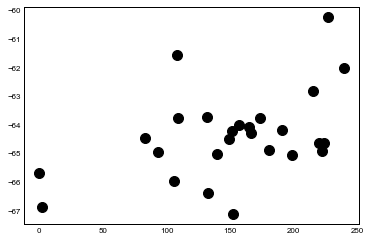

In [49]:
plt.scatter(ir[ir>0.1], vrest[ir>0.1])
plt.show()

In [50]:
ir_raw_all = np.concatenate(ir_raw)
print(np.mean(ir_raw_all[np.where(ir_raw_all>20)]))
vrest_raw_all = np.concatenate(vrest_raw)
print(np.mean(vrest_raw_all[np.where(vrest_raw_all<-50)]))

159.19613368352924
-65.12669918564778


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [51]:
ir_nonNan = ir_raw_all[np.where(ir_raw_all>20)]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


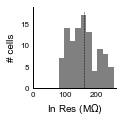

In [52]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(ir_nonNan, color='gray')
ax.vlines(x=np.mean(ir_nonNan), ymin=0., ymax= max(n) + 1, color='k', linestyles='--')
simpleaxis(ax)
ax.set_xlabel("In Res (M$\Omega$)")
ax.set_ylabel("# cells")
ax.set_xlim(xmin=0.)
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
plt.savefig("figures/supplementary/InRes.svg")
plt.show()
plt.close()

In [53]:
1./np.median(ir_nonNan)

0.006495832971515131

In [ ]:
1./min(ir_nonNan), 1./max(ir_nonNan)

In [59]:
?ax.vlines

$\frac{1}{k} E_{exc}\frac{R}{D} e^ { \frac{t_{peak}}{\tau_{exc}} (\frac{D}{R} - 1)}$

where, 

$D = 1 - \frac{\delta_{inh}}{t_{peak}}$ and $R = \frac{\tau_{inh}}{\tau_{exc}}$


Since no closed form exists for the solutions to Equation X, it is hard to solve for $t_{peak}$ and reduce this further. However, from the form of the equation, we can see that the term for inhibitory reversal scales the $V_{max}$ divisively. Because $E_{inh}~E_{leak}~0$, $\epsilon$ increases, even thought the inhibition reversal is close to leak (shunting), the observed V_{max}, $\theta$ keeps decreasing. This is the effect of shunting inhibition on the $V_{max}$.




## Proof for the conductance model based equation

$Cm\frac{dV_m}{dt} = g_{leak} (E_{leak} - V_m) + g_{exc}(t) (E_{exc} - V_m) + g_{inh}(t)(E_{inh} - V_m) $

Finding roots $V_{m} (t*)$, $Cm\frac{dV_m}{dt} = 0$

$g_{leak} (E_{leak} - V_m) + g_{exc}(t*) (E_{exc} - V_m) + g_{inh}(t*)(E_{inh} - V_m) = 0$ 

$g_{leak} (E_{leak} - V_m) + g_{exc}(t*) (E_{exc} - V_m) + g_{inh}(t*)(E_{inh} - V_m) = 0$

$g_{leak}E_{leak} + g_{exc}(t*)E_{exc}+ g_{inh}(t*)E_{inh} - V_m(g_{leak} + g_{exc}(t*) + g_{inh}(t*)) = 0$

or

$\begin{equation*}
V_m(t*) = \frac{g_{leak}E_{leak} + g_{exc}(t*)E_{exc}+ g_{inh}(t*)E_{inh}}{g_{leak} + g_{exc}(t*) + g_{inh}(t*)} \\
\theta = \frac{g_{leak}E_{leak} + g_{exc}(t*)E_{exc}+ g_{inh}(t*)E_{inh}}{g_{leak} + g_{exc}(t*) + g_{inh}(t*)} \\
\epsilon = \frac{g_{leak}E_{leak} + g_{exc}(t*)E_{exc}}{g_{leak} + g_{exc}(t*)} \\
\end{equation*}$

From 

</break>

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: Accessing existing paths using object constrcutors has been deprecated. Use  moose.element to access existing object. In future  this will be an error.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: Accessing existing paths using object constrcutors has been deprecated. Use  moose.element to access existing object. In future  this will be an error.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: Accessing existing paths using object constrcutors has been deprecated. Use  moose.element to access existing object. In future  this will be an error.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Accessing existing paths using object constrcutors has been deprecated. Use  moose.element to access existing object. In future  this will be an error.



2001


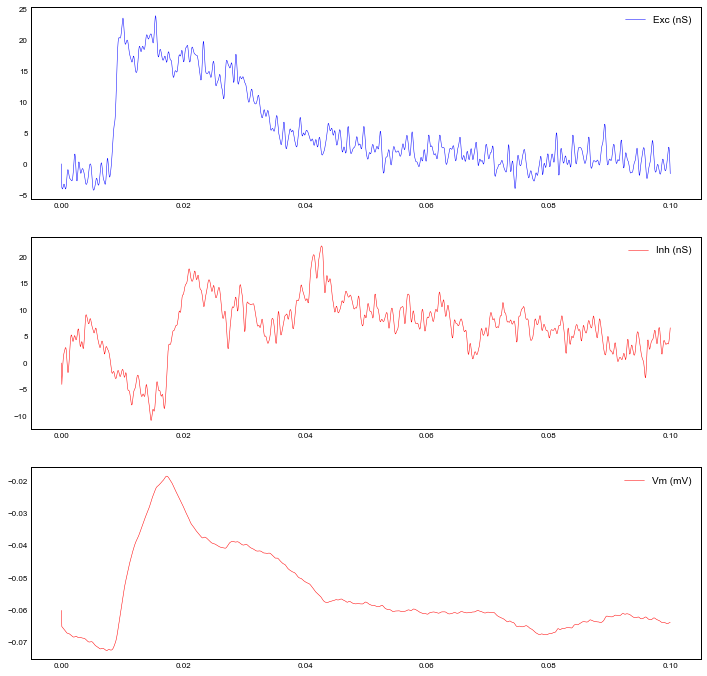

In [67]:
simtime = 100e-3
simdt = 50e-6

if moose.exists('/model'):
    moose.delete('/model')
model = moose.Neutral('/model')

tt_array_exc = moose.TimeTable('{}/{}'.format(model.path, 'table_exc'))
tt_array_inh = moose.TimeTable('{}/{}'.format(model.path, 'table_inh'))

tt_array_exc.vector = exc_traj
tt_array_inh.vector = inh_traj

comp = moose.Compartment('/model/comp')
comp.setInitVm(-65.e-3)
comp.Em = -65.0e-3
comp.Rm = 1e8
comp.Cm = 100e-12

exc = moose.Leakage('/model/comp/exc')
inh = moose.Leakage('/model/comp/inh')
moose.connect(exc, 'channel', comp, 'channel')
moose.connect(inh, 'channel', comp, 'channel')

exc.Gbar = 0.
exc.Ek = 0.0e-3
# exc.modulation = 1.

inh.Gbar = 0
inh.Ek = -70.0e-3
# inh.modulation = 1.

moose.connect(tt_array_exc, 'eventOut', exc, 'setGbar')
moose.connect(tt_array_inh, 'eventOut', inh, 'setGbar')

# Data recording: record the `state` of the time table filled
# using array.

data = moose.Neutral('/data')

tab_array_exc = moose.Table('/data/tab_array_exc')
tab_array_inh = moose.Table('/data/tab_array_inh')
tab_vm = moose.Table('/data/tab_array_vm')

moose.connect(tab_array_exc, 'requestOut', exc, 'getGk')
moose.connect(tab_array_inh, 'requestOut', inh, 'getGk')

moose.connect(tab_vm, 'requestOut', comp, 'getVm')

# Scheduling
moose.setClock(0, simdt)
moose.setClock(1, simdt)
moose.useClock(1, '/model/##[ISA=Compartment]', 'init')
moose.useClock(1, '/model/##,/data/##', 'process')
moose.reinit()

# moose.start(0.0001)
moose.start(simtime)

# Plotting
plt.subplot(3,1,1)

plt.plot(np.linspace(0, simtime, len(tab_array_exc.vector)), tab_array_exc.vector*1e9, 'b-', label='Exc (nS)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(np.linspace(0, simtime, len(tab_array_inh.vector)), tab_array_inh.vector*1e9, 'r-', label='Inh (nS)')
plt.legend()

plt.subplot(3,1,3)
plt.plot(np.linspace(0, simtime, len(tab_vm.vector)), tab_vm.vector, 'r-', label='Vm (mV)')
plt.legend()

print(len(tab_vm.vector))

fig = plt.gcf()
fig.set_figwidth(12)
fig.set_figheight(12)
plt.show()

In [91]:
import rdesigneur as rd

In [97]:
for k,l in n:
    print (k, l)

1 {1: <Linearity.Experiment instance at 0x7f8810ccbbd8>, 3: <Linearity.Experiment instance at 0x7f8810c8fb00>, 9: <Linearity.Experiment instance at 0x7f8810b9a9e0>, 5: <Linearity.Experiment instance at 0x7f8810bd8248>, 7: <Linearity.Experiment instance at 0x7f8810cef758>}
2 {1: <Linearity.Experiment instance at 0x7f8810b2a248>, 3: <Linearity.Experiment instance at 0x7f8810aed128>, 9: <Linearity.Experiment instance at 0x7f8810a764d0>, 5: <Linearity.Experiment instance at 0x7f8810ab23f8>, 7: <Linearity.Experiment instance at 0x7f8810b60d40>}
3 {1: <Linearity.Experiment instance at 0x7f8810a01098>, 3: <Linearity.Experiment instance at 0x7f88106bff38>, 9: <Linearity.Experiment instance at 0x7f881064c320>, 5: <Linearity.Experiment instance at 0x7f8810689248>, 7: <Linearity.Experiment instance at 0x7f8810a39b90>}
4 {3: <Linearity.Experiment instance at 0x7f881060e9e0>, 5: <Linearity.Experiment instance at 0x7f88105d38c0>, 7: <Linearity.Experiment instance at 0x7f88105197a0>}


In [ ]:
def makeModel():
    cd = [
            ['Na', 'soma', 'Gbar', '200' ],['K_DR', 'soma', 'Gbar', '250' ],
            ['K_A', 'soma', 'Gbar', str(K_A_Gbar) ],
    ]
     
    rdes = rd.rdesigneur(
        elecPlotDt = elecPlotDt,
        stealCellFromLibrary = True,
        verbose = False,
        chanProto = [
            #['make_glu()', 'glu'],['make_GABA()', 'GABA'],
            #['make_K_A()','K_A'],
            ['make_Na()', 'Na'],['make_K_DR()', 'K_DR'],
        ],
        cellProto = [['somaProto', 'cellBase', dia, dia]],
        passiveDistrib = [[ '#', 'RM', str(RM), 'CM', str(CM), 'RA', str(RA) ]],
        chanDistrib = cd,
        stimList = [
        ],
        plotList = [['soma', '1','.', 'Vm']],
    )
    #moose.element( '/library/GABA' ).Ek = -0.07
    
    rdes.buildModel()
    moose.element('/library/exc').setData() 
    moose.element('/library/inh').setData() 